In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting transit times

Fitting for or marginalizing over the transit times or transit timing variations (TTVs) can be useful for several reasons, and it is a compelling use case for `exoplanet` becuase the number of parameters in the model increases significantly because there will be a new parameter for each transit.
The performance of the NUTS sampler used by `exoplanet` scales well with the number of parameters, so a TTV model should be substantially faster to run to convergence with `exoplanet` than with other tools.
There are a few definitions and subtleties that should be considered before jumping in.

In this tutorial, we will be using a "descriptive" model :class:`orbits.TTVOrbit` to fit the light curve where the underlying motion is still Keplerian, but the time coordinate is warped to make `t0` a function of time.
All of the other orbital elements besides `t0` are shared across all orbits, but the `t0` for each transit will be a parameter.
This means that other variations (like transit duration variations) are not currently supported, but it would be possible to include more general effects.
`exoplanet` also supports photodynamics modeling using the :class:`orbits.ReboundOrbit` for more detailed analysis, but that is a topic for a future tutorial.

It is also important to note that "transit time" within `exoplanet` (and most other transit fitting software) is defined as the time of conjunction (called `t0` in the code): the time when the true anomaly is $\pi/2 - \omega$.
Section 18 of [the EXOFASTv2 paper](https://arxiv.org/abs/1907.09480) includes an excellent discussion of some of the commonly used definitions of "transit time" in the literature.

Finally, there is a subtlety in the definition of the "period" of an orbit with TTVs.
Two possible definitions are: (1) the average time between transits, or (2) the slope of a least squares fit to the transit times as a function of transit number.
In `exoplanet`, we use the latter definition and call this parameter the `ttv_period` to distinguish it from the `period` of the underlying Keplerian motion which sets the shape and duration of the transit.
By default, these two periods are constrained to be equal, but it can be useful to fit for both parameters since the shape of the transit might not be perfectly described by the same period.
That being said, if you fit for both periods, make sure that you constrain `ttv_period` and `period` to be similar or things can get a bit ugly.

To get started, let's generate some simulated transit times.
We'll use the :func:`orbits.ttv.compute_expected_transit_times` function to get the expected transit times for a linear ephemeris within some observation baseline:

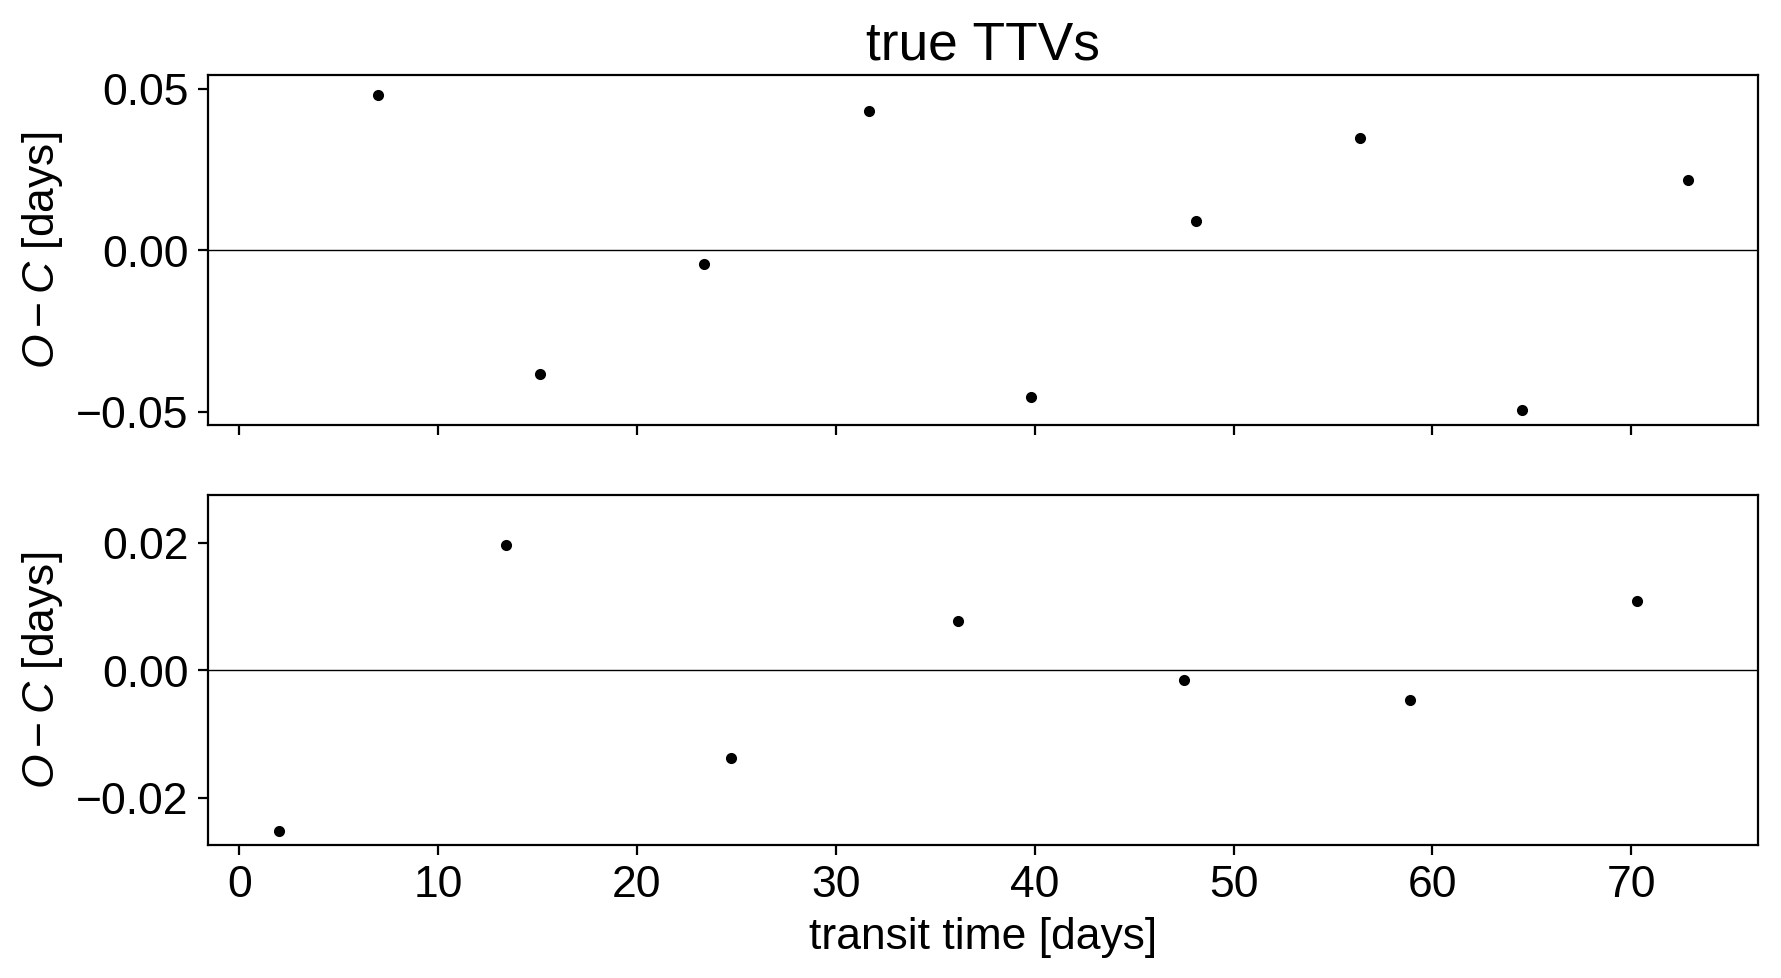

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

np.random.seed(3948)
true_periods = np.random.uniform(8, 12, 2)
true_t0s = true_periods * np.random.rand(2)
t = np.arange(0, 80, 0.01)
texp = 0.01
yerr = 5e-4

# Compute the transit times for a linear ephemeris
true_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    t.min(), t.max(), true_periods, true_t0s
)

# Simulate transit timing variations using a simple model
true_ttvs = [
    (0.05 - (i % 2) * 0.1) * np.sin(2 * np.pi * tt / 23.7)
    for i, tt in enumerate(true_transit_times)
]
true_transit_times = [tt + v for tt, v in zip(true_transit_times, true_ttvs)]

# Plot the true TTV model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(true_transit_times[0], true_ttvs[0], ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))
ax1.set_ylabel("$O-C$ [days]")

ax2.plot(true_transit_times[1], true_ttvs[1], ".k")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))
ax2.set_ylabel("$O-C$ [days]")

ax2.set_xlabel("transit time [days]")
ax1.set_title("true TTVs");

Now, like in the :ref:`transit` tutorial, we'll set up the the model using `PyMC3` and `exoplanet`, and then simulate a data set from that model.

In [4]:
import pymc3 as pm
import theano.tensor as tt

np.random.seed(9485023)

with pm.Model() as model:

    # This part of the model is similar to the model in the `transit` tutorial
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    logr = pm.Uniform(
        "logr",
        lower=np.log(0.01),
        upper=np.log(0.1),
        shape=2,
        testval=np.log([0.04, 0.06]),
    )
    r = pm.Deterministic("r", tt.exp(logr))
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=0.5 * np.random.rand(2)
    )

    # Now we have a parameter for each transit time for each planet:
    transit_times = []
    for i in range(2):
        transit_times.append(
            pm.Normal(
                "tts_{0}".format(i),
                mu=true_transit_times[i],
                sd=1.0,
                shape=len(true_transit_times[i]),
            )
        )

    # Set up an orbit for the planets
    orbit = xo.orbits.TTVOrbit(b=b, transit_times=transit_times)

    # It will be useful later to track some parameters of the orbit
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    for i in range(2):
        pm.Deterministic("ttvs_{0}".format(i), orbit.ttvs[i])

    # The rest of this block follows the transit fitting tutorial
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t, texp=texp
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    pm.Deterministic("light_curves", light_curves)
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    map_soln = model.test_point
    map_soln = xo.optimize(start=map_soln, vars=transit_times)
    map_soln = xo.optimize(start=map_soln, vars=[r, b])
    map_soln = xo.optimize(start=map_soln, vars=transit_times)
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [tts_1, tts_0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.945488e+04]

1it [00:00, 65.26it/s, logp=4.945488e+04]

2it [00:00, 96.14it/s, logp=4.945488e+04]

3it [00:00, 116.32it/s, logp=4.317367e+04]

4it [00:00, 132.36it/s, logp=4.919676e+04]

5it [00:00, 145.95it/s, logp=4.945996e+04]

6it [00:00, 156.69it/s, logp=4.944404e+04]

7it [00:00, 166.57it/s, logp=4.946088e+04]

8it [00:00, 174.88it/s, logp=4.946008e+04]

9it [00:00, 179.71it/s, logp=4.946120e+04]

10it [00:00, 179.67it/s, logp=4.945897e+04]

11it [00:00, 179.72it/s, logp=4.946124e+04]

12it [00:00, 180.57it/s, logp=4.946111e+04]

13it [00:00, 181.71it/s, logp=4.946124e+04]

14it [00:00, 184.04it/s, logp=4.946122e+04]

15it [00:00, 186.48it/s, logp=4.946124e+04]

16it [00:00, 189.76it/s, logp=4.946124e+04]

17it [00:00, 193.13it/s, logp=4.946124e+04]

18it [00:00, 196.05it/s, logp=4.946124e+04]

19it [00:00, 199.43it/s, logp=4.946124e+04]

20it [00:00, 202.36it/s, logp=4.946124e+04]

21it [00:00, 205.46it/s, logp=4.946124e+04]

22it [00:00, 213.70it/s, logp=4.946124e+04]

22it [00:00, 213.70it/s, logp=4.946124e+04]

23it [00:00, 213.70it/s, logp=4.946124e+04]

24it [00:00, 213.70it/s, logp=4.946124e+04]

25it [00:00, 213.70it/s, logp=4.946124e+04]

26it [00:00, 213.70it/s, logp=4.946124e+04]

27it [00:00, 213.70it/s, logp=4.946124e+04]

28it [00:00, 213.70it/s, logp=4.946124e+04]

29it [00:00, 213.70it/s, logp=4.946124e+04]

30it [00:00, 213.70it/s, logp=4.946124e+04]

31it [00:00, 213.70it/s, logp=4.946124e+04]

32it [00:00, 213.70it/s, logp=4.946125e+04]

33it [00:00, 213.70it/s, logp=4.946125e+04]

34it [00:00, 213.70it/s, logp=4.946126e+04]

35it [00:00, 213.70it/s, logp=4.946113e+04]

36it [00:00, 213.70it/s, logp=4.946126e+04]

37it [00:00, 213.70it/s, logp=4.946071e+04]

38it [00:00, 213.70it/s, logp=4.946126e+04]

39it [00:00, 213.70it/s, logp=4.946126e+04]

40it [00:00, 213.70it/s, logp=4.946126e+04]

41it [00:00, 213.70it/s, logp=4.946126e+04]

42it [00:00, 213.70it/s, logp=4.946126e+04]

43it [00:00, 213.70it/s, logp=4.946126e+04]

44it [00:00, 213.70it/s, logp=4.946127e+04]

45it [00:00, 213.70it/s, logp=4.946128e+04]

46it [00:00, 213.70it/s, logp=4.946128e+04]

47it [00:00, 213.70it/s, logp=4.946128e+04]

48it [00:00, 213.70it/s, logp=4.946128e+04]

49it [00:00, 227.19it/s, logp=4.946128e+04]

49it [00:00, 227.19it/s, logp=4.946128e+04]

50it [00:00, 227.19it/s, logp=4.946128e+04]

51it [00:00, 227.19it/s, logp=4.946128e+04]

52it [00:00, 227.19it/s, logp=4.946128e+04]

53it [00:00, 227.19it/s, logp=4.946128e+04]

54it [00:00, 227.19it/s, logp=4.946128e+04]

55it [00:00, 227.19it/s, logp=4.946128e+04]

56it [00:00, 227.19it/s, logp=4.946128e+04]

57it [00:00, 227.19it/s, logp=4.946128e+04]

58it [00:00, 227.19it/s, logp=4.946128e+04]

59it [00:00, 227.19it/s, logp=4.946128e+04]

60it [00:00, 227.19it/s, logp=4.946128e+04]

61it [00:00, 227.19it/s, logp=4.946128e+04]

62it [00:00, 227.19it/s, logp=4.946128e+04]

63it [00:00, 227.19it/s, logp=4.946128e+04]

64it [00:00, 227.19it/s, logp=4.946128e+04]

65it [00:00, 227.19it/s, logp=4.946128e+04]

66it [00:00, 227.19it/s, logp=4.946128e+04]

67it [00:00, 209.99it/s, logp=4.946128e+04]

67it [00:00, 209.99it/s, logp=4.946128e+04]

68it [00:00, 209.99it/s, logp=4.946128e+04]

69it [00:00, 209.99it/s, logp=4.946128e+04]

70it [00:00, 209.99it/s, logp=4.946128e+04]

71it [00:00, 209.99it/s, logp=4.946128e+04]

72it [00:00, 209.99it/s, logp=4.946128e+04]

73it [00:00, 209.99it/s, logp=4.946128e+04]

74it [00:00, 209.99it/s, logp=4.946128e+04]

75it [00:00, 209.99it/s, logp=4.946128e+04]

76it [00:00, 209.99it/s, logp=4.946128e+04]

77it [00:00, 209.99it/s, logp=4.946128e+04]

78it [00:00, 209.99it/s, logp=4.946128e+04]

79it [00:00, 209.99it/s, logp=4.946128e+04]

80it [00:00, 209.99it/s, logp=4.946128e+04]

81it [00:00, 209.99it/s, logp=4.946128e+04]

82it [00:00, 209.99it/s, logp=4.946128e+04]

83it [00:00, 209.99it/s, logp=4.946128e+04]

84it [00:00, 209.99it/s, logp=4.946128e+04]

85it [00:00, 209.99it/s, logp=4.946128e+04]

86it [00:00, 209.99it/s, logp=4.946128e+04]

87it [00:00, 209.99it/s, logp=4.946128e+04]

88it [00:00, 209.99it/s, logp=4.946128e+04]

89it [00:00, 209.99it/s, logp=4.946128e+04]

90it [00:00, 209.99it/s, logp=4.946128e+04]

91it [00:00, 209.99it/s, logp=4.946128e+04]

92it [00:00, 209.99it/s, logp=4.946128e+04]

93it [00:00, 209.99it/s, logp=4.946128e+04]

94it [00:00, 209.99it/s, logp=4.946128e+04]

95it [00:00, 209.99it/s, logp=4.946128e+04]

96it [00:00, 209.99it/s, logp=4.946128e+04]

97it [00:00, 209.99it/s, logp=4.946128e+04]

98it [00:00, 209.99it/s, logp=4.946128e+04]

99it [00:00, 209.99it/s, logp=4.946128e+04]

100it [00:00, 235.27it/s, logp=4.946128e+04]

100it [00:00, 235.27it/s, logp=4.946128e+04]

101it [00:00, 235.27it/s, logp=4.946128e+04]

102it [00:00, 235.27it/s, logp=4.946128e+04]

103it [00:00, 235.27it/s, logp=4.946128e+04]

104it [00:00, 235.27it/s, logp=4.946128e+04]

105it [00:00, 235.27it/s, logp=4.946128e+04]

106it [00:00, 235.27it/s, logp=4.946128e+04]

107it [00:00, 235.27it/s, logp=4.946128e+04]

108it [00:00, 235.27it/s, logp=4.946128e+04]

109it [00:00, 235.27it/s, logp=4.946128e+04]

110it [00:00, 235.27it/s, logp=4.946128e+04]

111it [00:00, 235.27it/s, logp=4.946128e+04]

112it [00:00, 235.27it/s, logp=4.946128e+04]

113it [00:00, 235.27it/s, logp=4.946128e+04]

114it [00:00, 235.27it/s, logp=4.946128e+04]

115it [00:00, 235.27it/s, logp=4.946128e+04]

116it [00:00, 235.27it/s, logp=4.946128e+04]

117it [00:00, 235.27it/s, logp=4.946128e+04]

118it [00:00, 235.27it/s, logp=4.946128e+04]

119it [00:00, 235.27it/s, logp=4.946128e+04]

120it [00:05, 22.66it/s, logp=4.946128e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 49454.87884962603 -> 49461.28172640355


optimizing logp for variables: [b, logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946128e+04]

1it [00:00, 141.78it/s, logp=4.946128e+04]

2it [00:00, 199.16it/s, logp=4.946128e+04]

3it [00:00, 224.61it/s, logp=4.877899e+04]

4it [00:00, 244.68it/s, logp=4.946162e+04]

5it [00:00, 250.02it/s, logp=4.946226e+04]

6it [00:00, 231.89it/s, logp=4.946182e+04]

7it [00:00, 230.17it/s, logp=4.946249e+04]

8it [00:00, 229.24it/s, logp=4.946224e+04]

9it [00:00, 230.64it/s, logp=4.946258e+04]

10it [00:00, 234.35it/s, logp=4.946275e+04]

11it [00:00, 237.60it/s, logp=4.946327e+04]

12it [00:00, 240.52it/s, logp=4.946356e+04]

13it [00:00, 242.76it/s, logp=4.946356e+04]

14it [00:00, 244.40it/s, logp=4.946356e+04]

15it [00:00, 245.67it/s, logp=4.946356e+04]

16it [00:00, 247.29it/s, logp=4.946356e+04]

17it [00:00, 248.74it/s, logp=4.946356e+04]

18it [00:00, 20.24it/s, logp=4.946356e+04] 


message: Optimization terminated successfully.
logp: 49461.28172640355 -> 49463.56218609357


optimizing logp for variables: [tts_1, tts_0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946356e+04]

1it [00:00, 82.77it/s, logp=4.946356e+04]

2it [00:00, 106.43it/s, logp=4.946356e+04]

3it [00:00, 115.68it/s, logp=4.419106e+04]

4it [00:00, 122.41it/s, logp=4.944272e+04]

5it [00:00, 129.66it/s, logp=4.946361e+04]

6it [00:00, 134.91it/s, logp=4.946308e+04]

7it [00:00, 142.44it/s, logp=4.946362e+04]

8it [00:00, 150.09it/s, logp=4.946362e+04]

9it [00:00, 157.24it/s, logp=4.946351e+04]

10it [00:00, 163.71it/s, logp=4.946362e+04]

11it [00:00, 169.78it/s, logp=4.946362e+04]

12it [00:00, 176.14it/s, logp=4.946362e+04]

13it [00:00, 180.59it/s, logp=4.946362e+04]

14it [00:00, 186.16it/s, logp=4.946362e+04]

15it [00:00, 191.48it/s, logp=4.946362e+04]

16it [00:00, 196.19it/s, logp=4.946362e+04]

17it [00:00, 200.69it/s, logp=4.946362e+04]

18it [00:00, 205.16it/s, logp=4.946362e+04]

19it [00:00, 208.86it/s, logp=4.946362e+04]

20it [00:00, 212.97it/s, logp=4.946362e+04]

21it [00:00, 216.38it/s, logp=4.946362e+04]

22it [00:00, 219.69it/s, logp=4.946362e+04]

23it [00:00, 228.39it/s, logp=4.946362e+04]

23it [00:00, 228.39it/s, logp=4.946362e+04]

24it [00:00, 228.39it/s, logp=4.946362e+04]

25it [00:00, 228.39it/s, logp=4.946362e+04]

26it [00:00, 228.39it/s, logp=4.946362e+04]

27it [00:00, 228.39it/s, logp=4.946362e+04]

28it [00:00, 228.39it/s, logp=4.946362e+04]

29it [00:00, 228.39it/s, logp=4.946363e+04]

30it [00:00, 228.39it/s, logp=4.946363e+04]

31it [00:00, 228.39it/s, logp=4.946332e+04]

32it [00:00, 228.39it/s, logp=4.946363e+04]

33it [00:00, 228.39it/s, logp=4.946363e+04]

34it [00:00, 228.39it/s, logp=4.946363e+04]

35it [00:00, 228.39it/s, logp=4.946363e+04]

36it [00:00, 228.39it/s, logp=4.946363e+04]

37it [00:00, 228.39it/s, logp=4.946363e+04]

38it [00:00, 228.39it/s, logp=4.946363e+04]

39it [00:00, 228.39it/s, logp=4.946363e+04]

40it [00:00, 228.39it/s, logp=4.946309e+04]

41it [00:00, 228.39it/s, logp=4.946363e+04]

42it [00:00, 228.39it/s, logp=4.946363e+04]

43it [00:00, 228.39it/s, logp=4.946363e+04]

44it [00:00, 228.39it/s, logp=4.946363e+04]

45it [00:00, 228.39it/s, logp=4.946363e+04]

46it [00:00, 226.25it/s, logp=4.946363e+04]

46it [00:00, 226.25it/s, logp=4.946363e+04]

47it [00:00, 226.25it/s, logp=4.946363e+04]

48it [00:00, 226.25it/s, logp=4.946363e+04]

49it [00:00, 226.25it/s, logp=4.946363e+04]

50it [00:00, 226.25it/s, logp=4.946363e+04]

51it [00:00, 226.25it/s, logp=4.946363e+04]

52it [00:00, 226.25it/s, logp=4.946363e+04]

53it [00:01, 47.23it/s, logp=4.946363e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 49463.56218609357 -> 49463.626773189084


optimizing logp for variables: [tts_1, tts_0, b, logr, u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=4.946363e+04]

1it [00:00, 142.60it/s, logp=4.946363e+04]

2it [00:00, 192.54it/s, logp=4.946363e+04]

3it [00:00, 217.19it/s, logp=-1.632146e+10]

4it [00:00, 232.52it/s, logp=4.946375e+04] 

5it [00:00, 244.26it/s, logp=4.945886e+04]

6it [00:00, 253.14it/s, logp=4.946375e+04]

7it [00:00, 258.39it/s, logp=4.946373e+04]

8it [00:00, 262.94it/s, logp=4.946375e+04]

9it [00:00, 266.27it/s, logp=4.946375e+04]

10it [00:00, 268.42it/s, logp=4.946375e+04]

11it [00:00, 269.79it/s, logp=4.946375e+04]

12it [00:00, 271.72it/s, logp=4.946375e+04]

13it [00:00, 272.45it/s, logp=4.946375e+04]

14it [00:00, 273.54it/s, logp=4.946375e+04]

15it [00:00, 272.11it/s, logp=4.946375e+04]

16it [00:00, 272.60it/s, logp=4.946375e+04]

17it [00:00, 274.84it/s, logp=4.946375e+04]

18it [00:00, 275.08it/s, logp=4.946375e+04]

19it [00:00, 275.72it/s, logp=4.946375e+04]

20it [00:00, 276.56it/s, logp=4.946375e+04]

21it [00:00, 277.72it/s, logp=4.946375e+04]

22it [00:00, 277.77it/s, logp=4.946375e+04]

23it [00:00, 278.28it/s, logp=4.946375e+04]

24it [00:00, 278.87it/s, logp=4.946375e+04]

25it [00:00, 279.51it/s, logp=4.946375e+04]

26it [00:00, 280.19it/s, logp=4.946375e+04]

27it [00:00, 281.11it/s, logp=4.946375e+04]

28it [00:00, 281.13it/s, logp=4.946375e+04]

29it [00:00, 289.48it/s, logp=4.946375e+04]

29it [00:00, 289.48it/s, logp=4.946367e+04]

30it [00:00, 289.48it/s, logp=4.946375e+04]

31it [00:00, 289.48it/s, logp=4.946375e+04]

32it [00:00, 289.48it/s, logp=4.946375e+04]

33it [00:00, 289.48it/s, logp=4.946375e+04]

34it [00:00, 289.48it/s, logp=4.946375e+04]

35it [00:00, 289.48it/s, logp=4.946374e+04]

36it [00:00, 289.48it/s, logp=4.946375e+04]

37it [00:00, 289.48it/s, logp=4.946375e+04]

38it [00:00, 289.48it/s, logp=4.946375e+04]

39it [00:00, 289.48it/s, logp=4.946376e+04]

40it [00:00, 289.48it/s, logp=4.946377e+04]

41it [00:00, 289.48it/s, logp=4.946382e+04]

42it [00:00, 289.48it/s, logp=4.946230e+04]

43it [00:00, 289.48it/s, logp=4.946383e+04]

44it [00:00, 289.48it/s, logp=4.946383e+04]

45it [00:00, 289.48it/s, logp=4.946386e+04]

46it [00:00, 289.48it/s, logp=4.946392e+04]

47it [00:00, 289.48it/s, logp=4.946400e+04]

48it [00:00, 289.48it/s, logp=4.946400e+04]

49it [00:00, 289.48it/s, logp=4.946400e+04]

50it [00:00, 289.48it/s, logp=4.946400e+04]

51it [00:00, 289.48it/s, logp=4.946400e+04]

52it [00:00, 289.48it/s, logp=4.946400e+04]

53it [00:00, 289.48it/s, logp=4.946400e+04]

54it [00:00, 289.48it/s, logp=4.946400e+04]

55it [00:00, 289.48it/s, logp=4.946400e+04]

56it [00:00, 289.48it/s, logp=4.946400e+04]

57it [00:00, 289.48it/s, logp=4.946400e+04]

58it [00:00, 289.29it/s, logp=4.946400e+04]

58it [00:00, 289.29it/s, logp=4.946400e+04]

59it [00:00, 289.29it/s, logp=4.946400e+04]

60it [00:00, 289.29it/s, logp=4.946400e+04]

61it [00:00, 289.29it/s, logp=4.946400e+04]

62it [00:00, 289.29it/s, logp=4.946400e+04]

63it [00:00, 289.29it/s, logp=4.946400e+04]

64it [00:00, 289.29it/s, logp=4.946400e+04]

65it [00:00, 289.29it/s, logp=4.946400e+04]

66it [00:00, 289.29it/s, logp=4.946400e+04]

67it [00:00, 289.29it/s, logp=4.946400e+04]

68it [00:00, 289.29it/s, logp=4.946400e+04]

69it [00:00, 289.29it/s, logp=4.946400e+04]

70it [00:00, 289.29it/s, logp=4.946400e+04]

71it [00:00, 289.29it/s, logp=4.946400e+04]

72it [00:00, 289.29it/s, logp=4.946400e+04]

73it [00:00, 289.29it/s, logp=4.946400e+04]

74it [00:00, 289.29it/s, logp=4.946400e+04]

75it [00:00, 289.29it/s, logp=4.946400e+04]

76it [00:00, 289.29it/s, logp=4.946400e+04]

77it [00:00, 289.29it/s, logp=4.946400e+04]

78it [00:00, 289.29it/s, logp=4.946400e+04]

79it [00:00, 289.29it/s, logp=4.946400e+04]

80it [00:00, 289.29it/s, logp=4.946400e+04]

81it [00:00, 289.29it/s, logp=4.946400e+04]

82it [00:00, 289.29it/s, logp=4.946400e+04]

83it [00:00, 289.29it/s, logp=4.946400e+04]

84it [00:00, 289.29it/s, logp=4.946400e+04]

85it [00:00, 289.29it/s, logp=4.946400e+04]

86it [00:00, 283.99it/s, logp=4.946400e+04]

86it [00:00, 283.99it/s, logp=4.946400e+04]

87it [00:00, 283.99it/s, logp=4.946400e+04]

88it [00:00, 283.99it/s, logp=4.946400e+04]

89it [00:00, 283.99it/s, logp=4.946400e+04]

90it [00:00, 283.99it/s, logp=4.946400e+04]

91it [00:00, 283.99it/s, logp=4.946400e+04]

92it [00:00, 283.99it/s, logp=4.946400e+04]

93it [00:00, 283.99it/s, logp=4.946400e+04]

94it [00:00, 283.99it/s, logp=4.946400e+04]

95it [00:00, 283.99it/s, logp=4.946400e+04]

96it [00:00, 283.99it/s, logp=4.946400e+04]

97it [00:00, 283.99it/s, logp=4.946400e+04]

98it [00:00, 283.99it/s, logp=4.946400e+04]

99it [00:00, 283.99it/s, logp=4.946400e+04]

100it [00:00, 283.99it/s, logp=4.946400e+04]

101it [00:00, 283.99it/s, logp=4.946400e+04]

102it [00:00, 283.99it/s, logp=4.946400e+04]

103it [00:00, 283.99it/s, logp=4.946400e+04]

104it [00:00, 283.99it/s, logp=4.946400e+04]

105it [00:00, 283.99it/s, logp=4.946400e+04]

106it [00:00, 283.99it/s, logp=4.946400e+04]

107it [00:00, 283.99it/s, logp=4.946400e+04]

108it [00:00, 283.99it/s, logp=4.946400e+04]

109it [00:00, 283.99it/s, logp=4.946400e+04]

110it [00:00, 283.99it/s, logp=4.946400e+04]

111it [00:00, 283.99it/s, logp=4.946400e+04]

112it [00:00, 283.99it/s, logp=4.946400e+04]

113it [00:01, 88.47it/s, logp=4.946400e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 49463.626773189084 -> 49464.004718781114


Here's our simulated light curve and the initial model:

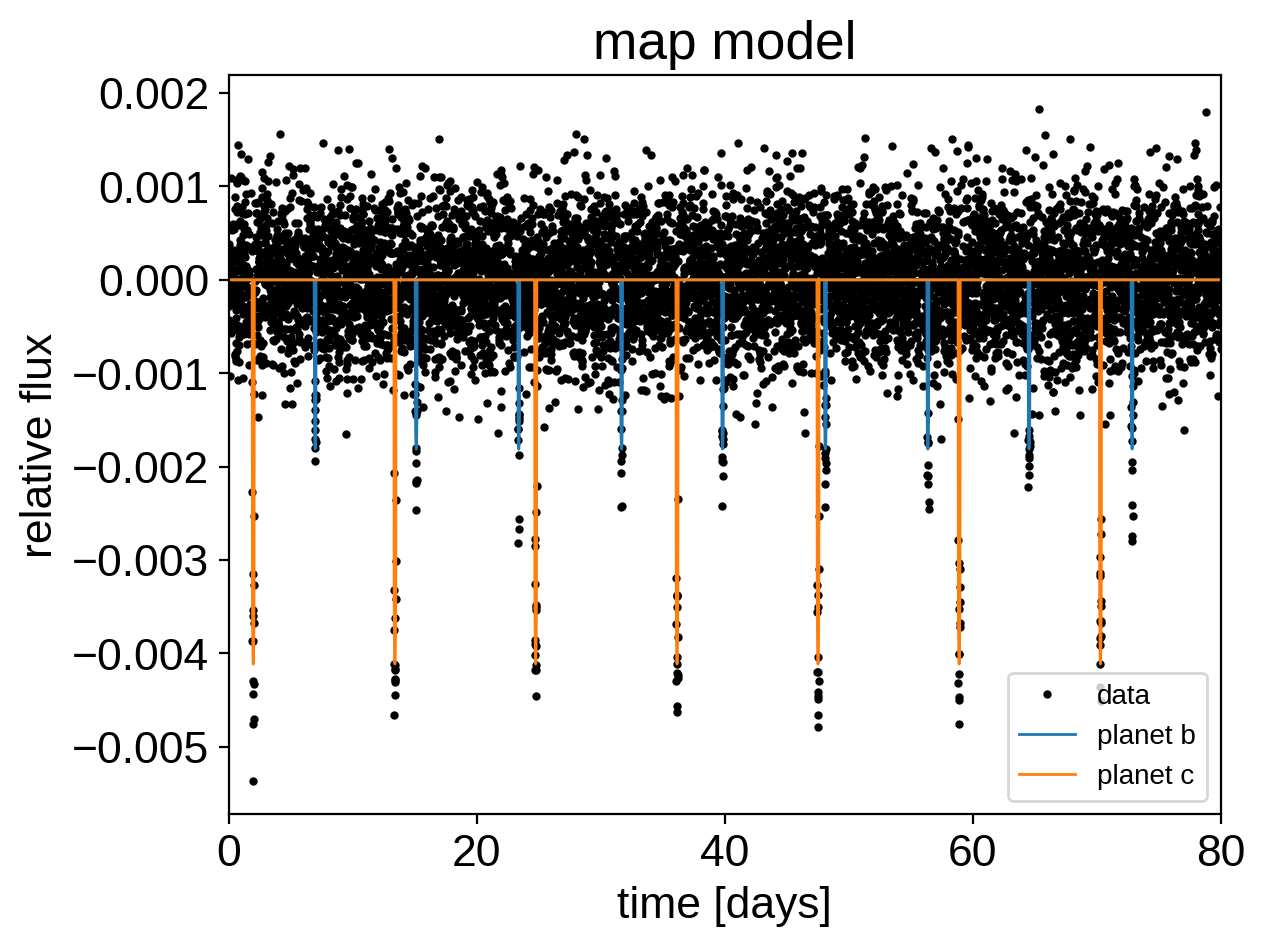

In [5]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

This looks similar to the light curve from the :ref:`transit` tutorial, but if we try plotting the folded transits, we can see that something isn't right: these transits look pretty smeared out!

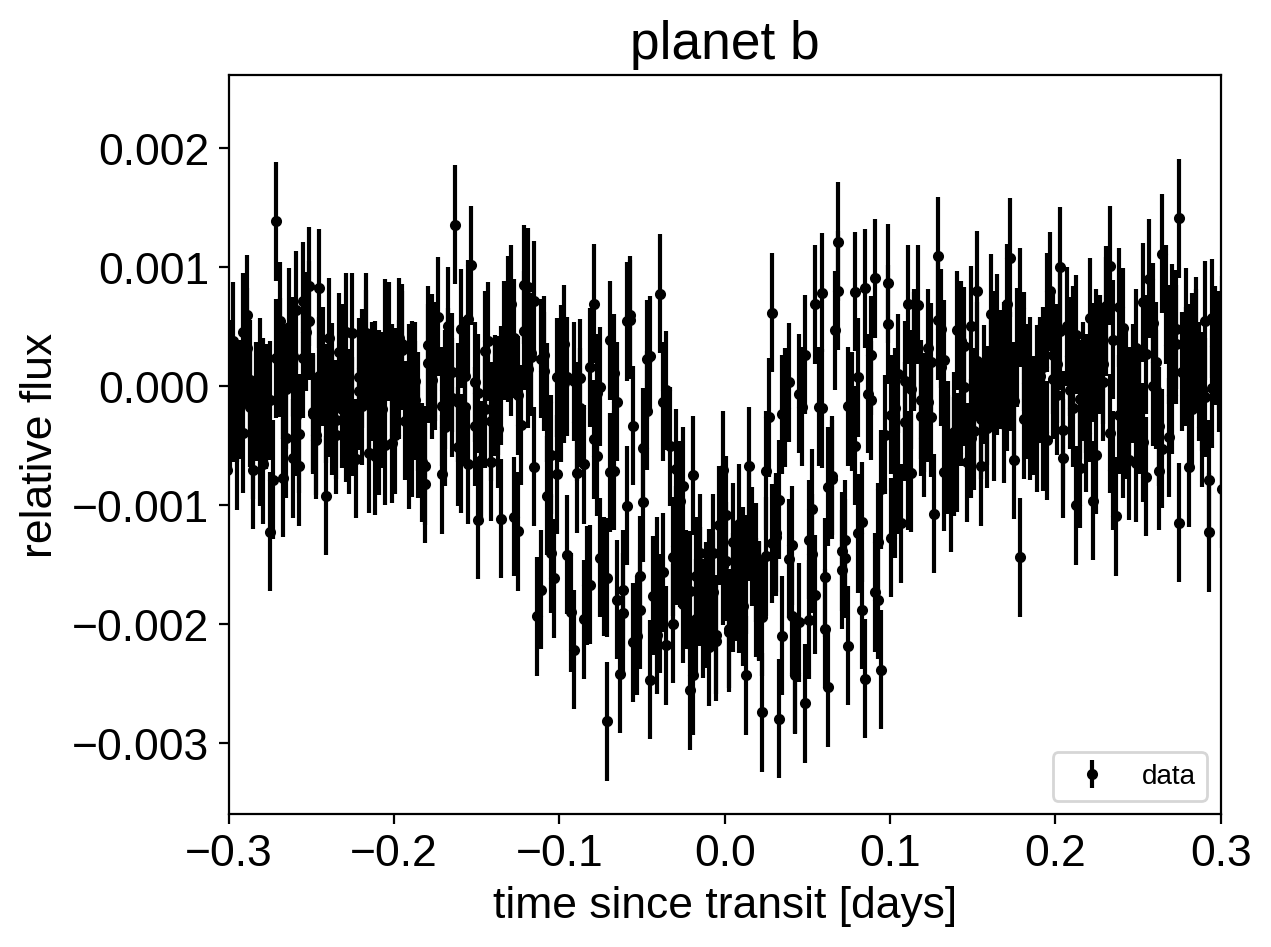

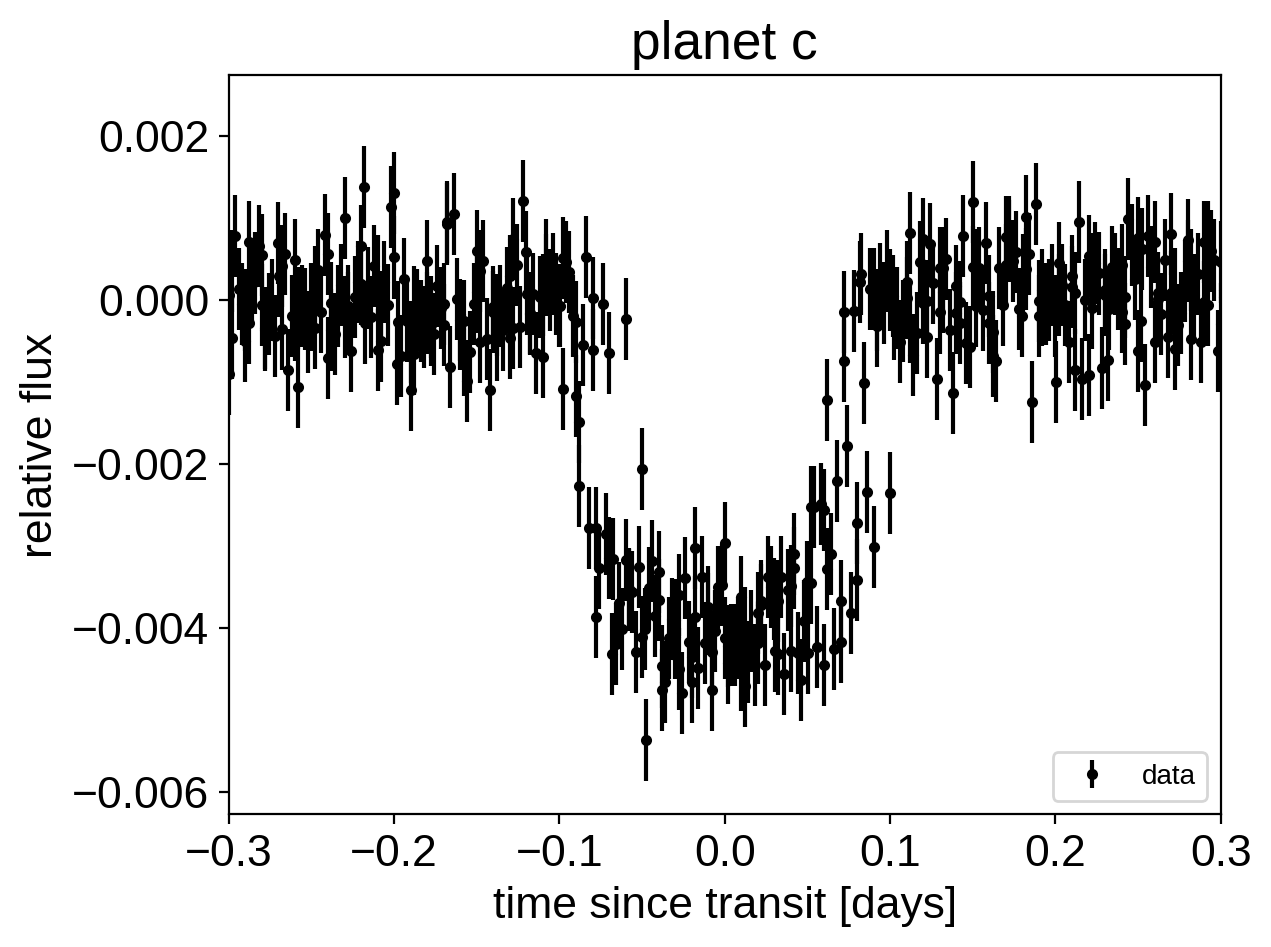

In [6]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = map_soln["period"][n]
    t0 = map_soln["t0"][n]

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

Instead, we can correct for the transit times by removing the best fit transit times and plot that instead:

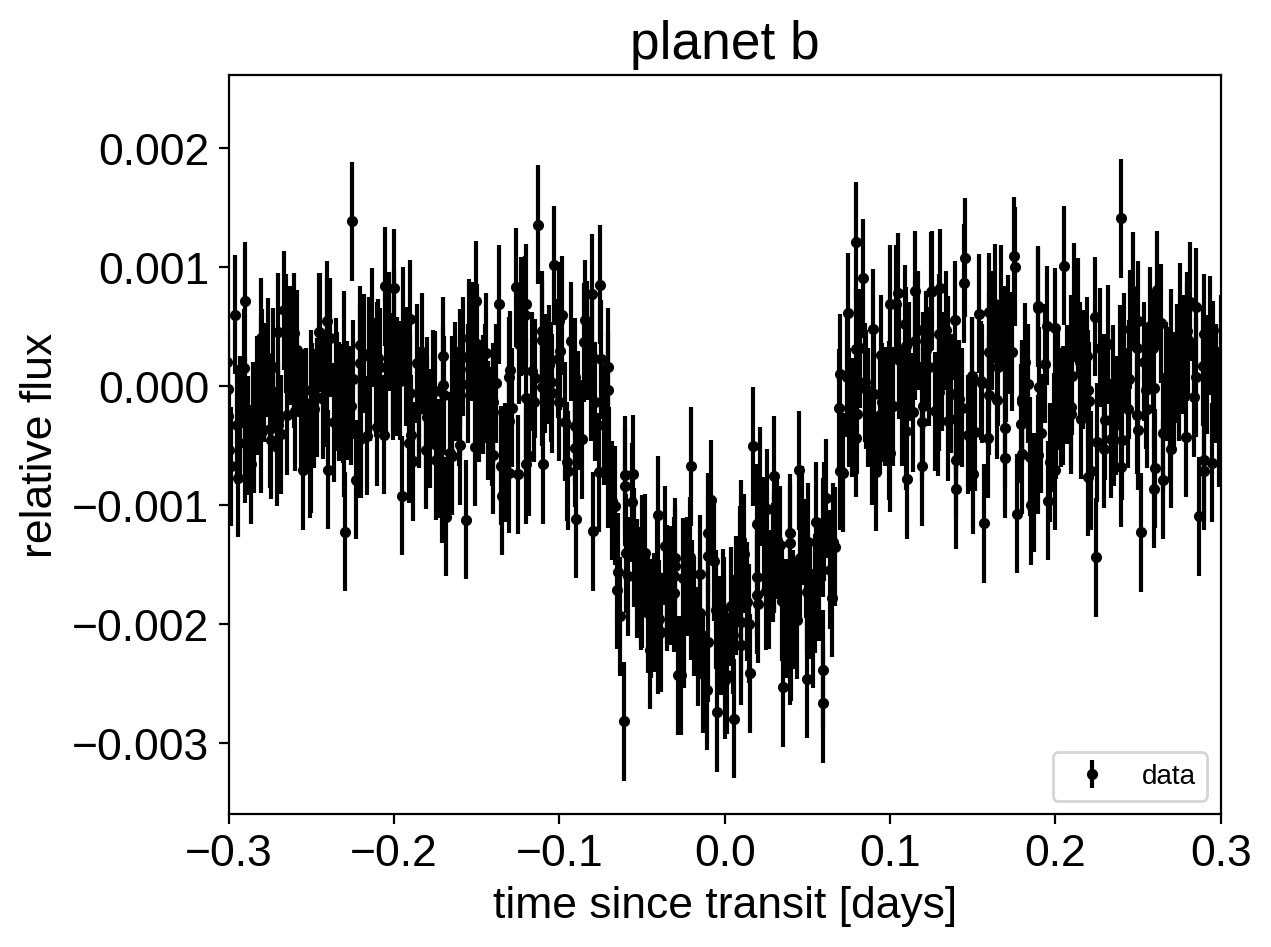

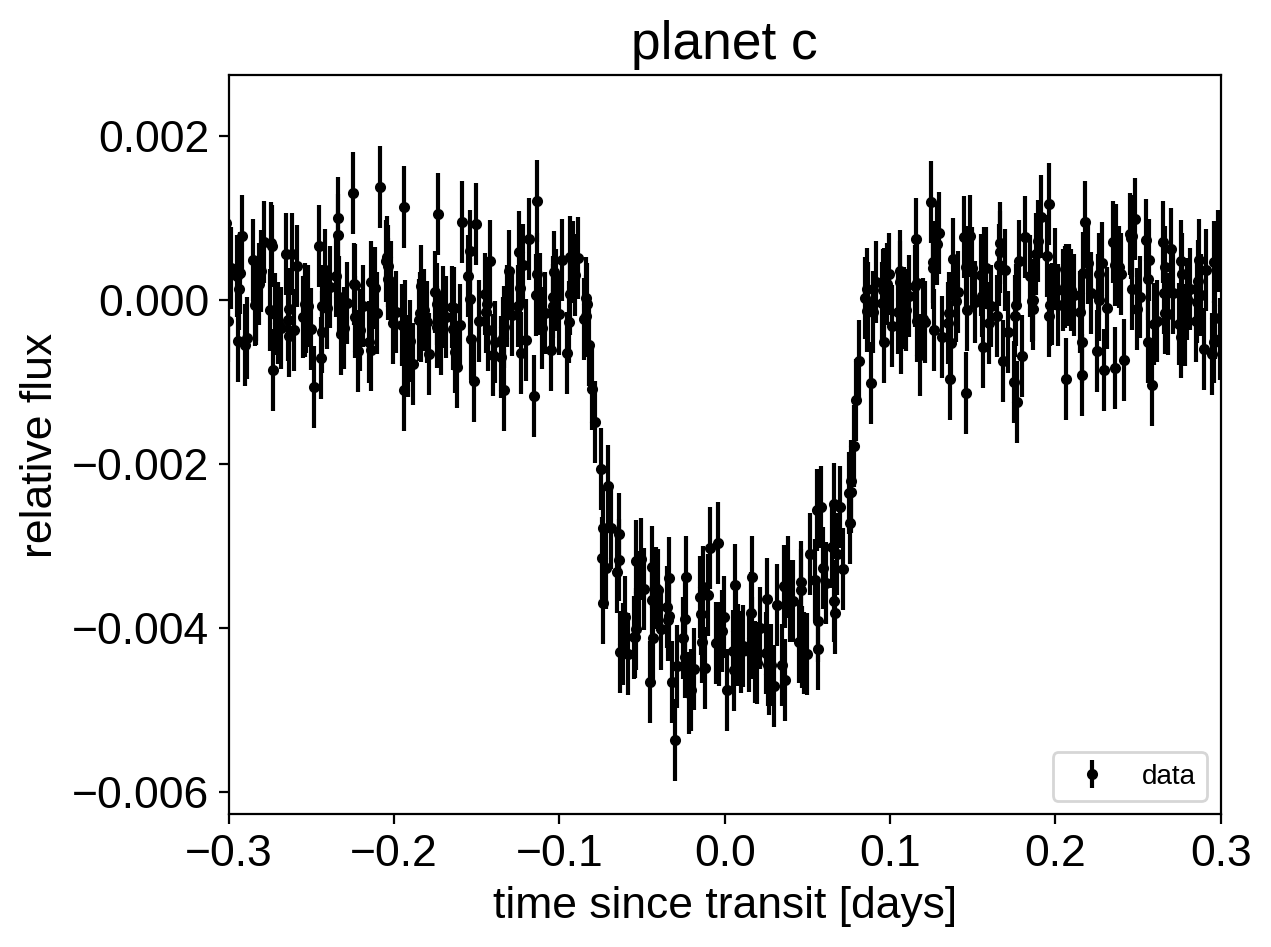

In [7]:
with model:
    t_warp = xo.eval_in_model(orbit._warp_times(t), map_soln)

for n, letter in enumerate("bc"):
    plt.figure()

    p = map_soln["period"][n]
    other = map_soln["light_curves"][:, (n + 1) % 2]

    # NOTE: 't0' has already been subtracted!
    x_fold = (t_warp[:, n] + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

That looks better!

## Sampling

Now let's run some MCMC as usual:

In [8]:
np.random.seed(230948)
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [tts_1, tts_0, b, logr, u, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 21/8000 [00:00<02:44, 48.40draws/s]

Sampling 4 chains:   0%|          | 24/8000 [00:00<03:45, 35.41draws/s]

Sampling 4 chains:   0%|          | 26/8000 [00:00<08:57, 14.84draws/s]

Sampling 4 chains:   0%|          | 28/8000 [00:01<09:54, 13.41draws/s]

Sampling 4 chains:   0%|          | 30/8000 [00:01<11:42, 11.35draws/s]

Sampling 4 chains:   0%|          | 32/8000 [00:01<12:20, 10.76draws/s]

Sampling 4 chains:   0%|          | 34/8000 [00:01<12:48, 10.37draws/s]

Sampling 4 chains:   0%|          | 36/8000 [00:01<13:37,  9.74draws/s]

Sampling 4 chains:   0%|          | 38/8000 [00:02<12:33, 10.56draws/s]

Sampling 4 chains:   0%|          | 40/8000 [00:02<15:26,  8.59draws/s]

Sampling 4 chains:   1%|          | 43/8000 [00:02<15:56,  8.32draws/s]

Sampling 4 chains:   1%|          | 46/8000 [00:02<13:12, 10.04draws/s]

Sampling 4 chains:   1%|          | 48/8000 [00:03<16:05,  8.23draws/s]

Sampling 4 chains:   1%|          | 50/8000 [00:03<14:13,  9.32draws/s]

Sampling 4 chains:   1%|          | 52/8000 [00:03<16:00,  8.28draws/s]

Sampling 4 chains:   1%|          | 54/8000 [00:04<15:59,  8.28draws/s]

Sampling 4 chains:   1%|          | 55/8000 [00:04<16:31,  8.01draws/s]

Sampling 4 chains:   1%|          | 58/8000 [00:04<17:06,  7.74draws/s]

Sampling 4 chains:   1%|          | 61/8000 [00:04<13:39,  9.69draws/s]

Sampling 4 chains:   1%|          | 63/8000 [00:05<16:24,  8.07draws/s]

Sampling 4 chains:   1%|          | 67/8000 [00:05<15:39,  8.44draws/s]

Sampling 4 chains:   1%|          | 72/8000 [00:05<14:13,  9.29draws/s]

Sampling 4 chains:   1%|          | 76/8000 [00:06<13:45,  9.60draws/s]

Sampling 4 chains:   1%|          | 78/8000 [00:06<13:03, 10.11draws/s]

Sampling 4 chains:   1%|          | 81/8000 [00:06<11:56, 11.05draws/s]

Sampling 4 chains:   1%|          | 84/8000 [00:06<12:28, 10.58draws/s]

Sampling 4 chains:   1%|          | 87/8000 [00:07<12:13, 10.79draws/s]

Sampling 4 chains:   1%|          | 89/8000 [00:07<13:40,  9.65draws/s]

Sampling 4 chains:   1%|          | 91/8000 [00:07<13:27,  9.80draws/s]

Sampling 4 chains:   1%|          | 93/8000 [00:07<13:44,  9.59draws/s]

Sampling 4 chains:   1%|          | 95/8000 [00:08<13:40,  9.63draws/s]

Sampling 4 chains:   1%|          | 96/8000 [00:08<16:54,  7.79draws/s]

Sampling 4 chains:   1%|          | 98/8000 [00:08<14:17,  9.22draws/s]

Sampling 4 chains:   1%|▏         | 101/8000 [00:08<13:56,  9.44draws/s]

Sampling 4 chains:   1%|▏         | 103/8000 [00:08<11:58, 10.99draws/s]

Sampling 4 chains:   1%|▏         | 105/8000 [00:09<13:48,  9.53draws/s]

Sampling 4 chains:   1%|▏         | 107/8000 [00:09<13:33,  9.70draws/s]

Sampling 4 chains:   1%|▏         | 109/8000 [00:09<13:41,  9.61draws/s]

Sampling 4 chains:   1%|▏         | 111/8000 [00:09<14:53,  8.83draws/s]

Sampling 4 chains:   1%|▏         | 113/8000 [00:09<14:17,  9.20draws/s]

Sampling 4 chains:   1%|▏         | 115/8000 [00:10<14:33,  9.03draws/s]

Sampling 4 chains:   1%|▏         | 117/8000 [00:10<15:05,  8.71draws/s]

Sampling 4 chains:   1%|▏         | 119/8000 [00:10<14:32,  9.03draws/s]

Sampling 4 chains:   2%|▏         | 121/8000 [00:10<14:36,  8.99draws/s]

Sampling 4 chains:   2%|▏         | 124/8000 [00:11<13:03, 10.05draws/s]

Sampling 4 chains:   2%|▏         | 127/8000 [00:11<11:35, 11.31draws/s]

Sampling 4 chains:   2%|▏         | 129/8000 [00:11<13:47,  9.52draws/s]

Sampling 4 chains:   2%|▏         | 131/8000 [00:11<11:40, 11.24draws/s]

Sampling 4 chains:   2%|▏         | 133/8000 [00:11<14:09,  9.26draws/s]

Sampling 4 chains:   2%|▏         | 135/8000 [00:12<12:46, 10.26draws/s]

Sampling 4 chains:   2%|▏         | 137/8000 [00:12<14:57,  8.76draws/s]

Sampling 4 chains:   2%|▏         | 139/8000 [00:12<14:43,  8.90draws/s]

Sampling 4 chains:   2%|▏         | 141/8000 [00:12<14:58,  8.75draws/s]

Sampling 4 chains:   2%|▏         | 144/8000 [00:13<13:47,  9.49draws/s]

Sampling 4 chains:   2%|▏         | 146/8000 [00:13<13:21,  9.80draws/s]

Sampling 4 chains:   2%|▏         | 148/8000 [00:13<14:19,  9.14draws/s]

Sampling 4 chains:   2%|▏         | 150/8000 [00:13<13:21,  9.80draws/s]

Sampling 4 chains:   2%|▏         | 152/8000 [00:14<14:26,  9.06draws/s]

Sampling 4 chains:   2%|▏         | 154/8000 [00:14<13:03, 10.02draws/s]

Sampling 4 chains:   2%|▏         | 156/8000 [00:14<14:34,  8.97draws/s]

Sampling 4 chains:   2%|▏         | 158/8000 [00:14<13:00, 10.05draws/s]

Sampling 4 chains:   2%|▏         | 160/8000 [00:14<14:26,  9.05draws/s]

Sampling 4 chains:   2%|▏         | 163/8000 [00:15<12:06, 10.79draws/s]

Sampling 4 chains:   2%|▏         | 165/8000 [00:15<13:28,  9.69draws/s]

Sampling 4 chains:   2%|▏         | 167/8000 [00:15<12:56, 10.09draws/s]

Sampling 4 chains:   2%|▏         | 169/8000 [00:15<14:15,  9.16draws/s]

Sampling 4 chains:   2%|▏         | 171/8000 [00:15<13:53,  9.39draws/s]

Sampling 4 chains:   2%|▏         | 173/8000 [00:16<13:53,  9.39draws/s]

Sampling 4 chains:   2%|▏         | 174/8000 [00:16<17:27,  7.47draws/s]

Sampling 4 chains:   2%|▏         | 177/8000 [00:16<15:16,  8.53draws/s]

Sampling 4 chains:   2%|▏         | 178/8000 [00:16<20:39,  6.31draws/s]

Sampling 4 chains:   2%|▏         | 181/8000 [00:17<16:47,  7.76draws/s]

Sampling 4 chains:   2%|▏         | 183/8000 [00:17<16:58,  7.67draws/s]

Sampling 4 chains:   2%|▏         | 185/8000 [00:17<14:15,  9.14draws/s]

Sampling 4 chains:   2%|▏         | 187/8000 [00:17<17:48,  7.31draws/s]

Sampling 4 chains:   2%|▏         | 191/8000 [00:18<16:20,  7.96draws/s]

Sampling 4 chains:   2%|▏         | 194/8000 [00:18<13:27,  9.67draws/s]

Sampling 4 chains:   2%|▏         | 196/8000 [00:18<16:10,  8.04draws/s]

Sampling 4 chains:   2%|▏         | 198/8000 [00:18<13:37,  9.55draws/s]

Sampling 4 chains:   2%|▎         | 200/8000 [00:19<13:27,  9.66draws/s]

Sampling 4 chains:   3%|▎         | 203/8000 [00:19<12:02, 10.79draws/s]

Sampling 4 chains:   3%|▎         | 205/8000 [00:19<13:16,  9.78draws/s]

Sampling 4 chains:   3%|▎         | 207/8000 [00:19<12:08, 10.69draws/s]

Sampling 4 chains:   3%|▎         | 209/8000 [00:19<12:56, 10.04draws/s]

Sampling 4 chains:   3%|▎         | 211/8000 [00:19<12:00, 10.82draws/s]

Sampling 4 chains:   3%|▎         | 213/8000 [00:20<13:05,  9.91draws/s]

Sampling 4 chains:   3%|▎         | 215/8000 [00:20<11:48, 10.98draws/s]

Sampling 4 chains:   3%|▎         | 217/8000 [00:20<13:42,  9.46draws/s]

Sampling 4 chains:   3%|▎         | 219/8000 [00:20<12:03, 10.75draws/s]

Sampling 4 chains:   3%|▎         | 221/8000 [00:21<13:14,  9.79draws/s]

Sampling 4 chains:   3%|▎         | 223/8000 [00:21<11:53, 10.89draws/s]

Sampling 4 chains:   3%|▎         | 225/8000 [00:21<13:08,  9.86draws/s]

Sampling 4 chains:   3%|▎         | 227/8000 [00:21<13:32,  9.56draws/s]

Sampling 4 chains:   3%|▎         | 229/8000 [00:21<12:35, 10.28draws/s]

Sampling 4 chains:   3%|▎         | 231/8000 [00:22<13:01,  9.94draws/s]

Sampling 4 chains:   3%|▎         | 233/8000 [00:22<12:16, 10.54draws/s]

Sampling 4 chains:   3%|▎         | 235/8000 [00:22<12:43, 10.16draws/s]

Sampling 4 chains:   3%|▎         | 237/8000 [00:22<12:15, 10.56draws/s]

Sampling 4 chains:   3%|▎         | 239/8000 [00:22<12:32, 10.32draws/s]

Sampling 4 chains:   3%|▎         | 241/8000 [00:22<12:10, 10.62draws/s]

Sampling 4 chains:   3%|▎         | 243/8000 [00:23<12:58,  9.97draws/s]

Sampling 4 chains:   3%|▎         | 245/8000 [00:23<13:02,  9.91draws/s]

Sampling 4 chains:   3%|▎         | 247/8000 [00:23<13:06,  9.86draws/s]

Sampling 4 chains:   3%|▎         | 248/8000 [00:23<13:05,  9.87draws/s]

Sampling 4 chains:   3%|▎         | 250/8000 [00:23<13:54,  9.29draws/s]

Sampling 4 chains:   3%|▎         | 252/8000 [00:24<12:14, 10.55draws/s]

Sampling 4 chains:   3%|▎         | 254/8000 [00:24<13:27,  9.59draws/s]

Sampling 4 chains:   3%|▎         | 256/8000 [00:24<11:48, 10.92draws/s]

Sampling 4 chains:   3%|▎         | 258/8000 [00:24<13:08,  9.82draws/s]

Sampling 4 chains:   3%|▎         | 260/8000 [00:24<11:36, 11.12draws/s]

Sampling 4 chains:   3%|▎         | 262/8000 [00:25<13:00,  9.91draws/s]

Sampling 4 chains:   3%|▎         | 264/8000 [00:25<11:53, 10.84draws/s]

Sampling 4 chains:   3%|▎         | 266/8000 [00:25<12:50, 10.04draws/s]

Sampling 4 chains:   3%|▎         | 268/8000 [00:25<12:14, 10.53draws/s]

Sampling 4 chains:   3%|▎         | 270/8000 [00:25<12:35, 10.23draws/s]

Sampling 4 chains:   3%|▎         | 272/8000 [00:25<11:25, 11.28draws/s]

Sampling 4 chains:   3%|▎         | 275/8000 [00:26<11:14, 11.44draws/s]

Sampling 4 chains:   3%|▎         | 277/8000 [00:26<11:40, 11.03draws/s]

Sampling 4 chains:   3%|▎         | 279/8000 [00:26<11:40, 11.02draws/s]

Sampling 4 chains:   4%|▎         | 281/8000 [00:26<12:56,  9.94draws/s]

Sampling 4 chains:   4%|▎         | 283/8000 [00:27<13:53,  9.26draws/s]

Sampling 4 chains:   4%|▎         | 284/8000 [00:27<14:48,  8.69draws/s]

Sampling 4 chains:   4%|▎         | 286/8000 [00:27<13:20,  9.64draws/s]

Sampling 4 chains:   4%|▎         | 288/8000 [00:27<14:20,  8.96draws/s]

Sampling 4 chains:   4%|▎         | 290/8000 [00:27<12:47, 10.04draws/s]

Sampling 4 chains:   4%|▎         | 292/8000 [00:27<13:27,  9.54draws/s]

Sampling 4 chains:   4%|▎         | 294/8000 [00:28<13:44,  9.34draws/s]

Sampling 4 chains:   4%|▎         | 296/8000 [00:28<13:17,  9.66draws/s]

Sampling 4 chains:   4%|▎         | 298/8000 [00:28<15:09,  8.47draws/s]

Sampling 4 chains:   4%|▎         | 299/8000 [00:28<15:23,  8.34draws/s]

Sampling 4 chains:   4%|▍         | 302/8000 [00:28<12:39, 10.13draws/s]

Sampling 4 chains:   4%|▍         | 304/8000 [00:29<14:03,  9.12draws/s]

Sampling 4 chains:   4%|▍         | 306/8000 [00:29<12:00, 10.67draws/s]

Sampling 4 chains:   4%|▍         | 308/8000 [00:29<13:29,  9.50draws/s]

Sampling 4 chains:   4%|▍         | 310/8000 [00:29<11:42, 10.94draws/s]

Sampling 4 chains:   4%|▍         | 312/8000 [00:30<13:56,  9.19draws/s]

Sampling 4 chains:   4%|▍         | 314/8000 [00:30<12:22, 10.35draws/s]

Sampling 4 chains:   4%|▍         | 316/8000 [00:30<15:11,  8.43draws/s]

Sampling 4 chains:   4%|▍         | 319/8000 [00:30<15:28,  8.27draws/s]

Sampling 4 chains:   4%|▍         | 323/8000 [00:31<14:33,  8.79draws/s]

Sampling 4 chains:   4%|▍         | 327/8000 [00:31<13:55,  9.18draws/s]

Sampling 4 chains:   4%|▍         | 331/8000 [00:32<13:27,  9.50draws/s]

Sampling 4 chains:   4%|▍         | 335/8000 [00:32<13:07,  9.73draws/s]

Sampling 4 chains:   4%|▍         | 339/8000 [00:32<12:50,  9.94draws/s]

Sampling 4 chains:   4%|▍         | 343/8000 [00:33<12:36, 10.12draws/s]

Sampling 4 chains:   4%|▍         | 347/8000 [00:33<12:35, 10.13draws/s]

Sampling 4 chains:   4%|▍         | 351/8000 [00:33<12:24, 10.28draws/s]

Sampling 4 chains:   4%|▍         | 355/8000 [00:34<12:16, 10.38draws/s]

Sampling 4 chains:   4%|▍         | 358/8000 [00:34<10:08, 12.56draws/s]

Sampling 4 chains:   4%|▍         | 360/8000 [00:34<12:43, 10.01draws/s]

Sampling 4 chains:   5%|▍         | 362/8000 [00:34<11:09, 11.42draws/s]

Sampling 4 chains:   5%|▍         | 364/8000 [00:35<12:56,  9.83draws/s]

Sampling 4 chains:   5%|▍         | 366/8000 [00:35<12:41, 10.03draws/s]

Sampling 4 chains:   5%|▍         | 368/8000 [00:35<12:36, 10.09draws/s]

Sampling 4 chains:   5%|▍         | 370/8000 [00:35<13:19,  9.55draws/s]

Sampling 4 chains:   5%|▍         | 372/8000 [00:35<12:09, 10.45draws/s]

Sampling 4 chains:   5%|▍         | 374/8000 [00:36<14:29,  8.77draws/s]

Sampling 4 chains:   5%|▍         | 378/8000 [00:36<14:01,  9.05draws/s]

Sampling 4 chains:   5%|▍         | 382/8000 [00:37<13:29,  9.41draws/s]

Sampling 4 chains:   5%|▍         | 386/8000 [00:37<12:59,  9.77draws/s]

Sampling 4 chains:   5%|▍         | 389/8000 [00:37<10:36, 11.97draws/s]

Sampling 4 chains:   5%|▍         | 391/8000 [00:37<14:22,  8.82draws/s]

Sampling 4 chains:   5%|▍         | 394/8000 [00:38<13:51,  9.14draws/s]

Sampling 4 chains:   5%|▍         | 396/8000 [00:38<12:19, 10.28draws/s]

Sampling 4 chains:   5%|▍         | 398/8000 [00:38<13:29,  9.39draws/s]

Sampling 4 chains:   5%|▌         | 400/8000 [00:38<11:54, 10.64draws/s]

Sampling 4 chains:   5%|▌         | 402/8000 [00:38<13:02,  9.71draws/s]

Sampling 4 chains:   5%|▌         | 404/8000 [00:39<11:42, 10.81draws/s]

Sampling 4 chains:   5%|▌         | 406/8000 [00:39<12:41,  9.97draws/s]

Sampling 4 chains:   5%|▌         | 408/8000 [00:39<11:39, 10.85draws/s]

Sampling 4 chains:   5%|▌         | 410/8000 [00:39<12:26, 10.17draws/s]

Sampling 4 chains:   5%|▌         | 412/8000 [00:39<11:41, 10.82draws/s]

Sampling 4 chains:   5%|▌         | 414/8000 [00:40<12:29, 10.13draws/s]

Sampling 4 chains:   5%|▌         | 416/8000 [00:40<11:43, 10.78draws/s]

Sampling 4 chains:   5%|▌         | 418/8000 [00:40<12:48,  9.87draws/s]

Sampling 4 chains:   5%|▌         | 420/8000 [00:40<11:37, 10.86draws/s]

Sampling 4 chains:   5%|▌         | 422/8000 [00:40<13:11,  9.58draws/s]

Sampling 4 chains:   5%|▌         | 424/8000 [00:41<11:28, 11.01draws/s]

Sampling 4 chains:   5%|▌         | 426/8000 [00:41<14:04,  8.97draws/s]

Sampling 4 chains:   5%|▌         | 429/8000 [00:41<12:30, 10.09draws/s]

Sampling 4 chains:   5%|▌         | 431/8000 [00:41<12:04, 10.44draws/s]

Sampling 4 chains:   5%|▌         | 433/8000 [00:41<12:28, 10.10draws/s]

Sampling 4 chains:   5%|▌         | 435/8000 [00:42<11:49, 10.66draws/s]

Sampling 4 chains:   5%|▌         | 437/8000 [00:42<12:34, 10.02draws/s]

Sampling 4 chains:   5%|▌         | 439/8000 [00:42<11:36, 10.85draws/s]

Sampling 4 chains:   6%|▌         | 441/8000 [00:42<12:39,  9.96draws/s]

Sampling 4 chains:   6%|▌         | 443/8000 [00:42<11:26, 11.01draws/s]

Sampling 4 chains:   6%|▌         | 445/8000 [00:43<12:49,  9.82draws/s]

Sampling 4 chains:   6%|▌         | 447/8000 [00:43<11:11, 11.25draws/s]

Sampling 4 chains:   6%|▌         | 449/8000 [00:43<12:58,  9.70draws/s]

Sampling 4 chains:   6%|▌         | 451/8000 [00:43<11:07, 11.31draws/s]

Sampling 4 chains:   6%|▌         | 453/8000 [00:43<13:09,  9.56draws/s]

Sampling 4 chains:   6%|▌         | 456/8000 [00:44<11:44, 10.71draws/s]

Sampling 4 chains:   6%|▌         | 458/8000 [00:44<13:15,  9.48draws/s]

Sampling 4 chains:   6%|▌         | 460/8000 [00:44<11:27, 10.97draws/s]

Sampling 4 chains:   6%|▌         | 462/8000 [00:44<12:59,  9.67draws/s]

Sampling 4 chains:   6%|▌         | 464/8000 [00:44<11:43, 10.71draws/s]

Sampling 4 chains:   6%|▌         | 466/8000 [00:45<12:53,  9.74draws/s]

Sampling 4 chains:   6%|▌         | 468/8000 [00:45<13:12,  9.51draws/s]

Sampling 4 chains:   6%|▌         | 470/8000 [00:45<12:36,  9.95draws/s]

Sampling 4 chains:   6%|▌         | 472/8000 [00:45<13:27,  9.33draws/s]

Sampling 4 chains:   6%|▌         | 473/8000 [00:45<14:24,  8.71draws/s]

Sampling 4 chains:   6%|▌         | 476/8000 [00:46<13:32,  9.26draws/s]

Sampling 4 chains:   6%|▌         | 477/8000 [00:46<13:18,  9.42draws/s]

Sampling 4 chains:   6%|▌         | 480/8000 [00:46<12:58,  9.66draws/s]

Sampling 4 chains:   6%|▌         | 482/8000 [00:46<11:08, 11.25draws/s]

Sampling 4 chains:   6%|▌         | 484/8000 [00:46<13:21,  9.38draws/s]

Sampling 4 chains:   6%|▌         | 487/8000 [00:47<11:22, 11.01draws/s]

Sampling 4 chains:   6%|▌         | 489/8000 [00:47<13:10,  9.50draws/s]

Sampling 4 chains:   6%|▌         | 491/8000 [00:47<11:27, 10.92draws/s]

Sampling 4 chains:   6%|▌         | 493/8000 [00:47<12:51,  9.73draws/s]

Sampling 4 chains:   6%|▌         | 495/8000 [00:47<11:29, 10.89draws/s]

Sampling 4 chains:   6%|▌         | 497/8000 [00:48<12:38,  9.90draws/s]

Sampling 4 chains:   6%|▌         | 499/8000 [00:48<11:40, 10.70draws/s]

Sampling 4 chains:   6%|▋         | 501/8000 [00:48<12:28, 10.02draws/s]

Sampling 4 chains:   6%|▋         | 503/8000 [00:48<12:11, 10.25draws/s]

Sampling 4 chains:   6%|▋         | 505/8000 [00:48<12:18, 10.15draws/s]

Sampling 4 chains:   6%|▋         | 507/8000 [00:49<12:41,  9.84draws/s]

Sampling 4 chains:   6%|▋         | 509/8000 [00:49<11:50, 10.55draws/s]

Sampling 4 chains:   6%|▋         | 511/8000 [00:49<12:50,  9.71draws/s]

Sampling 4 chains:   6%|▋         | 513/8000 [00:49<11:27, 10.88draws/s]

Sampling 4 chains:   6%|▋         | 515/8000 [00:49<13:09,  9.48draws/s]

Sampling 4 chains:   6%|▋         | 517/8000 [00:50<11:07, 11.21draws/s]

Sampling 4 chains:   6%|▋         | 519/8000 [00:50<13:17,  9.38draws/s]

Sampling 4 chains:   7%|▋         | 522/8000 [00:50<11:51, 10.50draws/s]

Sampling 4 chains:   7%|▋         | 524/8000 [00:50<12:48,  9.72draws/s]

Sampling 4 chains:   7%|▋         | 526/8000 [00:50<11:55, 10.45draws/s]

Sampling 4 chains:   7%|▋         | 528/8000 [00:51<12:34,  9.90draws/s]

Sampling 4 chains:   7%|▋         | 530/8000 [00:51<12:23, 10.05draws/s]

Sampling 4 chains:   7%|▋         | 532/8000 [00:51<12:16, 10.15draws/s]

Sampling 4 chains:   7%|▋         | 534/8000 [00:51<12:10, 10.22draws/s]

Sampling 4 chains:   7%|▋         | 536/8000 [00:51<11:52, 10.47draws/s]

Sampling 4 chains:   7%|▋         | 538/8000 [00:52<12:06, 10.27draws/s]

Sampling 4 chains:   7%|▋         | 540/8000 [00:52<11:40, 10.64draws/s]

Sampling 4 chains:   7%|▋         | 542/8000 [00:52<12:08, 10.24draws/s]

Sampling 4 chains:   7%|▋         | 544/8000 [00:52<11:31, 10.77draws/s]

Sampling 4 chains:   7%|▋         | 546/8000 [00:52<12:14, 10.15draws/s]

Sampling 4 chains:   7%|▋         | 548/8000 [00:53<11:26, 10.86draws/s]

Sampling 4 chains:   7%|▋         | 550/8000 [00:53<12:21, 10.05draws/s]

Sampling 4 chains:   7%|▋         | 552/8000 [00:53<11:19, 10.97draws/s]

Sampling 4 chains:   7%|▋         | 554/8000 [00:53<13:05,  9.48draws/s]

Sampling 4 chains:   7%|▋         | 556/8000 [00:53<11:03, 11.23draws/s]

Sampling 4 chains:   7%|▋         | 558/8000 [00:54<13:40,  9.07draws/s]

Sampling 4 chains:   7%|▋         | 561/8000 [00:54<14:14,  8.70draws/s]

Sampling 4 chains:   7%|▋         | 565/8000 [00:54<13:28,  9.19draws/s]

Sampling 4 chains:   7%|▋         | 569/8000 [00:55<12:54,  9.59draws/s]

Sampling 4 chains:   7%|▋         | 572/8000 [00:55<10:47, 11.47draws/s]

Sampling 4 chains:   7%|▋         | 574/8000 [00:55<12:14, 10.10draws/s]

Sampling 4 chains:   7%|▋         | 576/8000 [00:55<11:08, 11.11draws/s]

Sampling 4 chains:   7%|▋         | 578/8000 [00:55<10:09, 12.17draws/s]

Sampling 4 chains:   7%|▋         | 580/8000 [00:56<12:01, 10.29draws/s]

Sampling 4 chains:   7%|▋         | 582/8000 [00:56<10:30, 11.76draws/s]

Sampling 4 chains:   7%|▋         | 584/8000 [00:56<12:28,  9.90draws/s]

Sampling 4 chains:   7%|▋         | 586/8000 [00:56<10:49, 11.41draws/s]

Sampling 4 chains:   7%|▋         | 588/8000 [00:57<12:44,  9.70draws/s]

Sampling 4 chains:   7%|▋         | 592/8000 [00:57<11:31, 10.71draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [00:57<09:55, 12.43draws/s]

Sampling 4 chains:   7%|▋         | 596/8000 [00:57<12:02, 10.24draws/s]

Sampling 4 chains:   7%|▋         | 598/8000 [00:57<10:21, 11.92draws/s]

Sampling 4 chains:   8%|▊         | 600/8000 [00:57<10:37, 11.61draws/s]

Sampling 4 chains:   8%|▊         | 602/8000 [00:58<11:42, 10.53draws/s]

Sampling 4 chains:   8%|▊         | 605/8000 [00:58<10:00, 12.32draws/s]

Sampling 4 chains:   8%|▊         | 607/8000 [00:58<12:05, 10.19draws/s]

Sampling 4 chains:   8%|▊         | 609/8000 [00:58<10:19, 11.93draws/s]

Sampling 4 chains:   8%|▊         | 611/8000 [00:58<09:04, 13.56draws/s]

Sampling 4 chains:   8%|▊         | 613/8000 [00:58<09:44, 12.64draws/s]

Sampling 4 chains:   8%|▊         | 615/8000 [00:59<11:45, 10.46draws/s]

Sampling 4 chains:   8%|▊         | 617/8000 [00:59<10:18, 11.94draws/s]

Sampling 4 chains:   8%|▊         | 619/8000 [00:59<09:08, 13.45draws/s]

Sampling 4 chains:   8%|▊         | 621/8000 [00:59<09:58, 12.34draws/s]

Sampling 4 chains:   8%|▊         | 625/8000 [00:59<08:58, 13.70draws/s]

Sampling 4 chains:   8%|▊         | 628/8000 [01:00<07:45, 15.85draws/s]

Sampling 4 chains:   8%|▊         | 631/8000 [01:00<07:08, 17.21draws/s]

Sampling 4 chains:   8%|▊         | 634/8000 [01:00<06:34, 18.65draws/s]

Sampling 4 chains:   8%|▊         | 637/8000 [01:00<05:56, 20.65draws/s]

Sampling 4 chains:   8%|▊         | 640/8000 [01:00<05:24, 22.66draws/s]

Sampling 4 chains:   8%|▊         | 643/8000 [01:00<05:23, 22.76draws/s]

Sampling 4 chains:   8%|▊         | 648/8000 [01:00<04:49, 25.41draws/s]

Sampling 4 chains:   8%|▊         | 651/8000 [01:00<05:04, 24.13draws/s]

Sampling 4 chains:   8%|▊         | 656/8000 [01:01<04:20, 28.16draws/s]

Sampling 4 chains:   8%|▊         | 662/8000 [01:01<03:49, 31.93draws/s]

Sampling 4 chains:   8%|▊         | 668/8000 [01:01<03:24, 35.90draws/s]

Sampling 4 chains:   8%|▊         | 674/8000 [01:01<03:01, 40.44draws/s]

Sampling 4 chains:   8%|▊         | 679/8000 [01:01<02:56, 41.59draws/s]

Sampling 4 chains:   9%|▊         | 684/8000 [01:01<03:09, 38.53draws/s]

Sampling 4 chains:   9%|▊         | 689/8000 [01:01<03:08, 38.73draws/s]

Sampling 4 chains:   9%|▊         | 694/8000 [01:01<03:03, 39.84draws/s]

Sampling 4 chains:   9%|▊         | 699/8000 [01:01<02:57, 41.18draws/s]

Sampling 4 chains:   9%|▉         | 705/8000 [01:02<02:43, 44.70draws/s]

Sampling 4 chains:   9%|▉         | 712/8000 [01:02<02:26, 49.62draws/s]

Sampling 4 chains:   9%|▉         | 719/8000 [01:02<02:20, 51.79draws/s]

Sampling 4 chains:   9%|▉         | 728/8000 [01:02<02:06, 57.27draws/s]

Sampling 4 chains:   9%|▉         | 737/8000 [01:02<01:54, 63.25draws/s]

Sampling 4 chains:   9%|▉         | 745/8000 [01:02<01:48, 66.58draws/s]

Sampling 4 chains:   9%|▉         | 753/8000 [01:02<01:54, 63.27draws/s]

Sampling 4 chains:  10%|▉         | 760/8000 [01:02<01:57, 61.39draws/s]

Sampling 4 chains:  10%|▉         | 770/8000 [01:03<01:47, 67.46draws/s]

Sampling 4 chains:  10%|▉         | 783/8000 [01:03<01:31, 78.48draws/s]

Sampling 4 chains:  10%|▉         | 792/8000 [01:03<01:32, 78.09draws/s]

Sampling 4 chains:  10%|█         | 801/8000 [01:03<01:28, 81.31draws/s]

Sampling 4 chains:  10%|█         | 814/8000 [01:03<01:20, 89.15draws/s]

Sampling 4 chains:  10%|█         | 824/8000 [01:03<01:26, 82.68draws/s]

Sampling 4 chains:  10%|█         | 836/8000 [01:03<01:19, 90.15draws/s]

Sampling 4 chains:  11%|█         | 849/8000 [01:03<01:13, 97.78draws/s]

Sampling 4 chains:  11%|█         | 860/8000 [01:03<01:14, 95.68draws/s]

Sampling 4 chains:  11%|█         | 870/8000 [01:04<01:18, 91.24draws/s]

Sampling 4 chains:  11%|█         | 880/8000 [01:04<01:21, 87.28draws/s]

Sampling 4 chains:  11%|█         | 891/8000 [01:04<01:18, 90.18draws/s]

Sampling 4 chains:  11%|█▏        | 903/8000 [01:04<01:12, 97.23draws/s]

Sampling 4 chains:  11%|█▏        | 914/8000 [01:04<01:15, 93.94draws/s]

Sampling 4 chains:  12%|█▏        | 924/8000 [01:04<01:14, 95.54draws/s]

Sampling 4 chains:  12%|█▏        | 936/8000 [01:04<01:10, 100.59draws/s]

Sampling 4 chains:  12%|█▏        | 947/8000 [01:04<01:11, 99.17draws/s] 

Sampling 4 chains:  12%|█▏        | 958/8000 [01:04<01:10, 99.47draws/s]

Sampling 4 chains:  12%|█▏        | 973/8000 [01:05<01:05, 107.69draws/s]

Sampling 4 chains:  12%|█▏        | 985/8000 [01:05<01:07, 103.17draws/s]

Sampling 4 chains:  12%|█▏        | 996/8000 [01:05<01:08, 102.08draws/s]

Sampling 4 chains:  13%|█▎        | 1013/8000 [01:05<01:00, 115.02draws/s]

Sampling 4 chains:  13%|█▎        | 1026/8000 [01:05<00:59, 116.65draws/s]

Sampling 4 chains:  13%|█▎        | 1039/8000 [01:05<01:00, 115.08draws/s]

Sampling 4 chains:  13%|█▎        | 1056/8000 [01:05<00:56, 123.10draws/s]

Sampling 4 chains:  13%|█▎        | 1070/8000 [01:05<00:54, 127.04draws/s]

Sampling 4 chains:  14%|█▎        | 1084/8000 [01:05<00:55, 124.25draws/s]

Sampling 4 chains:  14%|█▎        | 1097/8000 [01:06<00:58, 118.38draws/s]

Sampling 4 chains:  14%|█▍        | 1110/8000 [01:06<00:57, 119.44draws/s]

Sampling 4 chains:  14%|█▍        | 1123/8000 [01:06<01:00, 113.25draws/s]

Sampling 4 chains:  14%|█▍        | 1138/8000 [01:06<00:56, 122.13draws/s]

Sampling 4 chains:  14%|█▍        | 1151/8000 [01:06<00:55, 122.49draws/s]

Sampling 4 chains:  15%|█▍        | 1167/8000 [01:06<00:52, 130.68draws/s]

Sampling 4 chains:  15%|█▍        | 1185/8000 [01:06<00:49, 138.79draws/s]

Sampling 4 chains:  15%|█▌        | 1204/8000 [01:06<00:46, 145.89draws/s]

Sampling 4 chains:  15%|█▌        | 1222/8000 [01:06<00:44, 153.33draws/s]

Sampling 4 chains:  15%|█▌        | 1239/8000 [01:07<00:44, 152.82draws/s]

Sampling 4 chains:  16%|█▌        | 1256/8000 [01:07<00:43, 154.42draws/s]

Sampling 4 chains:  16%|█▌        | 1272/8000 [01:07<00:45, 148.90draws/s]

Sampling 4 chains:  16%|█▌        | 1289/8000 [01:07<00:44, 152.46draws/s]

Sampling 4 chains:  16%|█▋        | 1305/8000 [01:07<00:43, 153.95draws/s]

Sampling 4 chains:  17%|█▋        | 1324/8000 [01:07<00:42, 157.63draws/s]

Sampling 4 chains:  17%|█▋        | 1341/8000 [01:07<00:41, 158.90draws/s]

Sampling 4 chains:  17%|█▋        | 1360/8000 [01:07<00:40, 165.49draws/s]

Sampling 4 chains:  17%|█▋        | 1377/8000 [01:07<00:41, 161.03draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8000 [01:08<00:39, 168.98draws/s]

Sampling 4 chains:  18%|█▊        | 1415/8000 [01:08<00:38, 169.79draws/s]

Sampling 4 chains:  18%|█▊        | 1435/8000 [01:08<00:37, 176.11draws/s]

Sampling 4 chains:  18%|█▊        | 1453/8000 [01:08<00:38, 171.06draws/s]

Sampling 4 chains:  18%|█▊        | 1471/8000 [01:08<00:41, 156.05draws/s]

Sampling 4 chains:  19%|█▊        | 1487/8000 [01:08<00:42, 153.06draws/s]

Sampling 4 chains:  19%|█▉        | 1503/8000 [01:08<00:42, 153.98draws/s]

Sampling 4 chains:  19%|█▉        | 1523/8000 [01:08<00:39, 163.07draws/s]

Sampling 4 chains:  19%|█▉        | 1541/8000 [01:08<00:38, 167.03draws/s]

Sampling 4 chains:  19%|█▉        | 1559/8000 [01:09<00:38, 165.95draws/s]

Sampling 4 chains:  20%|█▉        | 1576/8000 [01:09<00:40, 160.16draws/s]

Sampling 4 chains:  20%|█▉        | 1593/8000 [01:09<00:39, 160.25draws/s]

Sampling 4 chains:  20%|██        | 1610/8000 [01:09<00:39, 159.80draws/s]

Sampling 4 chains:  20%|██        | 1628/8000 [01:09<00:39, 162.44draws/s]

Sampling 4 chains:  21%|██        | 1645/8000 [01:09<00:40, 157.41draws/s]

Sampling 4 chains:  21%|██        | 1661/8000 [01:09<00:40, 155.54draws/s]

Sampling 4 chains:  21%|██        | 1680/8000 [01:09<00:38, 163.71draws/s]

Sampling 4 chains:  21%|██        | 1697/8000 [01:09<00:39, 161.18draws/s]

Sampling 4 chains:  21%|██▏       | 1714/8000 [01:10<00:39, 160.26draws/s]

Sampling 4 chains:  22%|██▏       | 1731/8000 [01:10<00:42, 147.98draws/s]

Sampling 4 chains:  22%|██▏       | 1748/8000 [01:10<00:40, 153.52draws/s]

Sampling 4 chains:  22%|██▏       | 1766/8000 [01:10<00:39, 159.73draws/s]

Sampling 4 chains:  22%|██▏       | 1783/8000 [01:10<00:38, 160.60draws/s]

Sampling 4 chains:  23%|██▎       | 1803/8000 [01:10<00:36, 170.12draws/s]

Sampling 4 chains:  23%|██▎       | 1821/8000 [01:10<00:38, 160.38draws/s]

Sampling 4 chains:  23%|██▎       | 1838/8000 [01:10<00:40, 152.54draws/s]

Sampling 4 chains:  23%|██▎       | 1855/8000 [01:10<00:39, 155.92draws/s]

Sampling 4 chains:  23%|██▎       | 1874/8000 [01:11<00:37, 163.30draws/s]

Sampling 4 chains:  24%|██▎       | 1891/8000 [01:11<00:37, 164.56draws/s]

Sampling 4 chains:  24%|██▍       | 1908/8000 [01:11<00:38, 158.68draws/s]

Sampling 4 chains:  24%|██▍       | 1926/8000 [01:11<00:37, 160.50draws/s]

Sampling 4 chains:  24%|██▍       | 1943/8000 [01:11<00:40, 150.08draws/s]

Sampling 4 chains:  24%|██▍       | 1959/8000 [01:11<00:40, 149.34draws/s]

Sampling 4 chains:  25%|██▍       | 1976/8000 [01:11<00:38, 154.80draws/s]

Sampling 4 chains:  25%|██▍       | 1993/8000 [01:11<00:38, 157.22draws/s]

Sampling 4 chains:  25%|██▌       | 2013/8000 [01:11<00:35, 167.77draws/s]

Sampling 4 chains:  25%|██▌       | 2031/8000 [01:11<00:35, 165.86draws/s]

Sampling 4 chains:  26%|██▌       | 2048/8000 [01:12<00:37, 160.47draws/s]

Sampling 4 chains:  26%|██▌       | 2068/8000 [01:12<00:35, 167.29draws/s]

Sampling 4 chains:  26%|██▌       | 2085/8000 [01:12<00:36, 163.44draws/s]

Sampling 4 chains:  26%|██▋       | 2102/8000 [01:12<00:40, 146.84draws/s]

Sampling 4 chains:  26%|██▋       | 2119/8000 [01:12<00:39, 149.37draws/s]

Sampling 4 chains:  27%|██▋       | 2138/8000 [01:12<00:37, 156.76draws/s]

Sampling 4 chains:  27%|██▋       | 2157/8000 [01:12<00:35, 164.66draws/s]

Sampling 4 chains:  27%|██▋       | 2176/8000 [01:12<00:34, 169.87draws/s]

Sampling 4 chains:  27%|██▋       | 2194/8000 [01:12<00:34, 169.48draws/s]

Sampling 4 chains:  28%|██▊       | 2212/8000 [01:13<00:35, 161.31draws/s]

Sampling 4 chains:  28%|██▊       | 2229/8000 [01:13<00:35, 162.17draws/s]

Sampling 4 chains:  28%|██▊       | 2246/8000 [01:13<00:36, 159.51draws/s]

Sampling 4 chains:  28%|██▊       | 2263/8000 [01:13<00:36, 156.66draws/s]

Sampling 4 chains:  28%|██▊       | 2279/8000 [01:13<00:36, 157.23draws/s]

Sampling 4 chains:  29%|██▊       | 2299/8000 [01:13<00:34, 166.89draws/s]

Sampling 4 chains:  29%|██▉       | 2318/8000 [01:13<00:33, 171.07draws/s]

Sampling 4 chains:  29%|██▉       | 2336/8000 [01:13<00:34, 163.23draws/s]

Sampling 4 chains:  29%|██▉       | 2356/8000 [01:13<00:33, 167.75draws/s]

Sampling 4 chains:  30%|██▉       | 2373/8000 [01:14<00:34, 164.09draws/s]

Sampling 4 chains:  30%|██▉       | 2392/8000 [01:14<00:33, 168.44draws/s]

Sampling 4 chains:  30%|███       | 2410/8000 [01:14<00:32, 171.51draws/s]

Sampling 4 chains:  30%|███       | 2428/8000 [01:14<00:33, 165.13draws/s]

Sampling 4 chains:  31%|███       | 2445/8000 [01:14<00:34, 162.33draws/s]

Sampling 4 chains:  31%|███       | 2463/8000 [01:14<00:33, 167.18draws/s]

Sampling 4 chains:  31%|███       | 2480/8000 [01:14<00:33, 165.97draws/s]

Sampling 4 chains:  31%|███       | 2497/8000 [01:14<00:34, 160.23draws/s]

Sampling 4 chains:  31%|███▏      | 2514/8000 [01:14<00:34, 160.74draws/s]

Sampling 4 chains:  32%|███▏      | 2531/8000 [01:15<00:34, 158.78draws/s]

Sampling 4 chains:  32%|███▏      | 2549/8000 [01:15<00:33, 164.10draws/s]

Sampling 4 chains:  32%|███▏      | 2569/8000 [01:15<00:31, 172.91draws/s]

Sampling 4 chains:  32%|███▏      | 2587/8000 [01:15<00:32, 165.73draws/s]

Sampling 4 chains:  33%|███▎      | 2604/8000 [01:15<00:32, 165.61draws/s]

Sampling 4 chains:  33%|███▎      | 2621/8000 [01:15<00:32, 163.65draws/s]

Sampling 4 chains:  33%|███▎      | 2639/8000 [01:15<00:32, 164.36draws/s]

Sampling 4 chains:  33%|███▎      | 2657/8000 [01:15<00:32, 166.17draws/s]

Sampling 4 chains:  33%|███▎      | 2674/8000 [01:15<00:33, 161.01draws/s]

Sampling 4 chains:  34%|███▎      | 2692/8000 [01:16<00:33, 160.83draws/s]

Sampling 4 chains:  34%|███▍      | 2710/8000 [01:16<00:32, 162.49draws/s]

Sampling 4 chains:  34%|███▍      | 2728/8000 [01:16<00:32, 164.01draws/s]

Sampling 4 chains:  34%|███▍      | 2746/8000 [01:16<00:31, 167.27draws/s]

Sampling 4 chains:  35%|███▍      | 2765/8000 [01:16<00:30, 172.41draws/s]

Sampling 4 chains:  35%|███▍      | 2783/8000 [01:16<00:30, 173.58draws/s]

Sampling 4 chains:  35%|███▌      | 2802/8000 [01:16<00:29, 177.45draws/s]

Sampling 4 chains:  35%|███▌      | 2820/8000 [01:16<00:30, 169.21draws/s]

Sampling 4 chains:  35%|███▌      | 2838/8000 [01:16<00:30, 169.09draws/s]

Sampling 4 chains:  36%|███▌      | 2855/8000 [01:16<00:31, 162.40draws/s]

Sampling 4 chains:  36%|███▌      | 2872/8000 [01:17<00:33, 154.14draws/s]

Sampling 4 chains:  36%|███▌      | 2891/8000 [01:17<00:31, 162.76draws/s]

Sampling 4 chains:  36%|███▋      | 2908/8000 [01:17<00:32, 156.98draws/s]

Sampling 4 chains:  37%|███▋      | 2927/8000 [01:17<00:31, 159.53draws/s]

Sampling 4 chains:  37%|███▋      | 2945/8000 [01:17<00:30, 164.44draws/s]

Sampling 4 chains:  37%|███▋      | 2963/8000 [01:17<00:30, 164.76draws/s]

Sampling 4 chains:  37%|███▋      | 2981/8000 [01:17<00:29, 168.43draws/s]

Sampling 4 chains:  37%|███▋      | 2998/8000 [01:17<00:30, 166.51draws/s]

Sampling 4 chains:  38%|███▊      | 3015/8000 [01:17<00:29, 166.79draws/s]

Sampling 4 chains:  38%|███▊      | 3032/8000 [01:18<00:30, 164.91draws/s]

Sampling 4 chains:  38%|███▊      | 3049/8000 [01:18<00:30, 164.53draws/s]

Sampling 4 chains:  38%|███▊      | 3067/8000 [01:18<00:30, 163.35draws/s]

Sampling 4 chains:  39%|███▊      | 3084/8000 [01:18<00:29, 164.90draws/s]

Sampling 4 chains:  39%|███▉      | 3101/8000 [01:18<00:29, 164.18draws/s]

Sampling 4 chains:  39%|███▉      | 3118/8000 [01:18<00:29, 163.37draws/s]

Sampling 4 chains:  39%|███▉      | 3136/8000 [01:18<00:29, 167.39draws/s]

Sampling 4 chains:  39%|███▉      | 3153/8000 [01:18<00:29, 165.47draws/s]

Sampling 4 chains:  40%|███▉      | 3172/8000 [01:18<00:28, 171.20draws/s]

Sampling 4 chains:  40%|███▉      | 3190/8000 [01:19<00:28, 169.87draws/s]

Sampling 4 chains:  40%|████      | 3208/8000 [01:19<00:28, 170.96draws/s]

Sampling 4 chains:  40%|████      | 3226/8000 [01:19<00:31, 153.71draws/s]

Sampling 4 chains:  41%|████      | 3242/8000 [01:19<00:32, 147.94draws/s]

Sampling 4 chains:  41%|████      | 3259/8000 [01:19<00:31, 152.53draws/s]

Sampling 4 chains:  41%|████      | 3275/8000 [01:19<00:30, 154.04draws/s]

Sampling 4 chains:  41%|████      | 3291/8000 [01:19<00:30, 155.52draws/s]

Sampling 4 chains:  41%|████▏     | 3309/8000 [01:19<00:29, 158.71draws/s]

Sampling 4 chains:  42%|████▏     | 3325/8000 [01:19<00:29, 156.26draws/s]

Sampling 4 chains:  42%|████▏     | 3341/8000 [01:20<00:30, 155.20draws/s]

Sampling 4 chains:  42%|████▏     | 3361/8000 [01:20<00:28, 160.15draws/s]

Sampling 4 chains:  42%|████▏     | 3378/8000 [01:20<00:28, 161.55draws/s]

Sampling 4 chains:  42%|████▏     | 3397/8000 [01:20<00:27, 165.37draws/s]

Sampling 4 chains:  43%|████▎     | 3417/8000 [01:20<00:26, 172.75draws/s]

Sampling 4 chains:  43%|████▎     | 3436/8000 [01:20<00:25, 175.65draws/s]

Sampling 4 chains:  43%|████▎     | 3455/8000 [01:20<00:25, 178.42draws/s]

Sampling 4 chains:  43%|████▎     | 3473/8000 [01:20<00:26, 173.65draws/s]

Sampling 4 chains:  44%|████▎     | 3491/8000 [01:20<00:25, 174.37draws/s]

Sampling 4 chains:  44%|████▍     | 3509/8000 [01:20<00:26, 170.95draws/s]

Sampling 4 chains:  44%|████▍     | 3531/8000 [01:21<00:25, 178.37draws/s]

Sampling 4 chains:  44%|████▍     | 3549/8000 [01:21<00:25, 175.13draws/s]

Sampling 4 chains:  45%|████▍     | 3567/8000 [01:21<00:26, 165.28draws/s]

Sampling 4 chains:  45%|████▍     | 3585/8000 [01:21<00:26, 165.81draws/s]

Sampling 4 chains:  45%|████▌     | 3602/8000 [01:21<00:26, 163.54draws/s]

Sampling 4 chains:  45%|████▌     | 3619/8000 [01:21<00:26, 164.19draws/s]

Sampling 4 chains:  45%|████▌     | 3636/8000 [01:21<00:26, 163.39draws/s]

Sampling 4 chains:  46%|████▌     | 3653/8000 [01:21<00:26, 161.42draws/s]

Sampling 4 chains:  46%|████▌     | 3672/8000 [01:21<00:25, 167.07draws/s]

Sampling 4 chains:  46%|████▌     | 3689/8000 [01:22<00:25, 166.21draws/s]

Sampling 4 chains:  46%|████▋     | 3706/8000 [01:22<00:25, 165.98draws/s]

Sampling 4 chains:  47%|████▋     | 3723/8000 [01:22<00:26, 158.99draws/s]

Sampling 4 chains:  47%|████▋     | 3739/8000 [01:22<00:27, 153.68draws/s]

Sampling 4 chains:  47%|████▋     | 3755/8000 [01:22<00:27, 155.03draws/s]

Sampling 4 chains:  47%|████▋     | 3771/8000 [01:22<00:27, 154.56draws/s]

Sampling 4 chains:  47%|████▋     | 3787/8000 [01:22<00:29, 143.97draws/s]

Sampling 4 chains:  48%|████▊     | 3803/8000 [01:22<00:28, 147.59draws/s]

Sampling 4 chains:  48%|████▊     | 3818/8000 [01:22<00:28, 148.17draws/s]

Sampling 4 chains:  48%|████▊     | 3835/8000 [01:23<00:27, 151.71draws/s]

Sampling 4 chains:  48%|████▊     | 3852/8000 [01:23<00:26, 155.89draws/s]

Sampling 4 chains:  48%|████▊     | 3869/8000 [01:23<00:26, 157.81draws/s]

Sampling 4 chains:  49%|████▊     | 3888/8000 [01:23<00:24, 165.06draws/s]

Sampling 4 chains:  49%|████▉     | 3905/8000 [01:23<00:24, 165.49draws/s]

Sampling 4 chains:  49%|████▉     | 3922/8000 [01:23<00:24, 166.32draws/s]

Sampling 4 chains:  49%|████▉     | 3939/8000 [01:23<00:24, 163.18draws/s]

Sampling 4 chains:  49%|████▉     | 3956/8000 [01:23<00:24, 162.13draws/s]

Sampling 4 chains:  50%|████▉     | 3974/8000 [01:23<00:24, 167.01draws/s]

Sampling 4 chains:  50%|████▉     | 3992/8000 [01:23<00:23, 168.81draws/s]

Sampling 4 chains:  50%|█████     | 4009/8000 [01:24<00:23, 166.31draws/s]

Sampling 4 chains:  50%|█████     | 4026/8000 [01:24<00:24, 164.12draws/s]

Sampling 4 chains:  51%|█████     | 4044/8000 [01:24<00:23, 165.67draws/s]

Sampling 4 chains:  51%|█████     | 4062/8000 [01:24<00:23, 168.68draws/s]

Sampling 4 chains:  51%|█████     | 4080/8000 [01:24<00:22, 170.50draws/s]

Sampling 4 chains:  51%|█████     | 4098/8000 [01:24<00:23, 166.82draws/s]

Sampling 4 chains:  51%|█████▏    | 4115/8000 [01:24<00:23, 165.07draws/s]

Sampling 4 chains:  52%|█████▏    | 4132/8000 [01:24<00:23, 164.41draws/s]

Sampling 4 chains:  52%|█████▏    | 4149/8000 [01:24<00:23, 161.33draws/s]

Sampling 4 chains:  52%|█████▏    | 4166/8000 [01:25<00:24, 159.20draws/s]

Sampling 4 chains:  52%|█████▏    | 4184/8000 [01:25<00:23, 163.90draws/s]

Sampling 4 chains:  53%|█████▎    | 4201/8000 [01:25<00:23, 164.44draws/s]

Sampling 4 chains:  53%|█████▎    | 4219/8000 [01:25<00:22, 165.36draws/s]

Sampling 4 chains:  53%|█████▎    | 4236/8000 [01:25<00:22, 164.05draws/s]

Sampling 4 chains:  53%|█████▎    | 4253/8000 [01:25<00:23, 156.88draws/s]

Sampling 4 chains:  53%|█████▎    | 4269/8000 [01:25<00:23, 157.47draws/s]

Sampling 4 chains:  54%|█████▎    | 4286/8000 [01:25<00:23, 159.07draws/s]

Sampling 4 chains:  54%|█████▍    | 4302/8000 [01:25<00:23, 158.87draws/s]

Sampling 4 chains:  54%|█████▍    | 4319/8000 [01:25<00:22, 160.66draws/s]

Sampling 4 chains:  54%|█████▍    | 4336/8000 [01:26<00:23, 158.56draws/s]

Sampling 4 chains:  54%|█████▍    | 4353/8000 [01:26<00:22, 159.98draws/s]

Sampling 4 chains:  55%|█████▍    | 4372/8000 [01:26<00:22, 160.11draws/s]

Sampling 4 chains:  55%|█████▍    | 4389/8000 [01:26<00:22, 162.19draws/s]

Sampling 4 chains:  55%|█████▌    | 4406/8000 [01:26<00:21, 164.00draws/s]

Sampling 4 chains:  55%|█████▌    | 4425/8000 [01:26<00:21, 169.58draws/s]

Sampling 4 chains:  56%|█████▌    | 4444/8000 [01:26<00:20, 172.02draws/s]

Sampling 4 chains:  56%|█████▌    | 4462/8000 [01:26<00:20, 172.27draws/s]

Sampling 4 chains:  56%|█████▌    | 4481/8000 [01:26<00:20, 172.27draws/s]

Sampling 4 chains:  56%|█████▌    | 4499/8000 [01:27<00:20, 172.22draws/s]

Sampling 4 chains:  56%|█████▋    | 4517/8000 [01:27<00:20, 166.99draws/s]

Sampling 4 chains:  57%|█████▋    | 4536/8000 [01:27<00:20, 169.92draws/s]

Sampling 4 chains:  57%|█████▋    | 4554/8000 [01:27<00:20, 164.59draws/s]

Sampling 4 chains:  57%|█████▋    | 4571/8000 [01:27<00:20, 164.45draws/s]

Sampling 4 chains:  57%|█████▋    | 4588/8000 [01:27<00:20, 164.29draws/s]

Sampling 4 chains:  58%|█████▊    | 4605/8000 [01:27<00:20, 163.11draws/s]

Sampling 4 chains:  58%|█████▊    | 4623/8000 [01:27<00:20, 167.27draws/s]

Sampling 4 chains:  58%|█████▊    | 4640/8000 [01:27<00:21, 159.09draws/s]

Sampling 4 chains:  58%|█████▊    | 4658/8000 [01:28<00:20, 163.48draws/s]

Sampling 4 chains:  58%|█████▊    | 4675/8000 [01:28<00:20, 162.40draws/s]

Sampling 4 chains:  59%|█████▊    | 4692/8000 [01:28<00:20, 161.92draws/s]

Sampling 4 chains:  59%|█████▉    | 4709/8000 [01:28<00:20, 161.86draws/s]

Sampling 4 chains:  59%|█████▉    | 4727/8000 [01:28<00:20, 162.46draws/s]

Sampling 4 chains:  59%|█████▉    | 4744/8000 [01:28<00:21, 151.94draws/s]

Sampling 4 chains:  60%|█████▉    | 4760/8000 [01:28<00:21, 150.41draws/s]

Sampling 4 chains:  60%|█████▉    | 4776/8000 [01:28<00:23, 138.17draws/s]

Sampling 4 chains:  60%|█████▉    | 4791/8000 [01:28<00:23, 137.94draws/s]

Sampling 4 chains:  60%|██████    | 4805/8000 [01:29<00:24, 131.16draws/s]

Sampling 4 chains:  60%|██████    | 4820/8000 [01:29<00:23, 132.64draws/s]

Sampling 4 chains:  60%|██████    | 4836/8000 [01:29<00:22, 138.18draws/s]

Sampling 4 chains:  61%|██████    | 4852/8000 [01:29<00:21, 143.72draws/s]

Sampling 4 chains:  61%|██████    | 4867/8000 [01:29<00:21, 142.80draws/s]

Sampling 4 chains:  61%|██████    | 4882/8000 [01:29<00:21, 142.97draws/s]

Sampling 4 chains:  61%|██████    | 4898/8000 [01:29<00:21, 145.59draws/s]

Sampling 4 chains:  61%|██████▏   | 4913/8000 [01:29<00:21, 143.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4929/8000 [01:29<00:21, 144.33draws/s]

Sampling 4 chains:  62%|██████▏   | 4945/8000 [01:30<00:21, 144.19draws/s]

Sampling 4 chains:  62%|██████▏   | 4960/8000 [01:30<00:21, 140.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4975/8000 [01:30<00:21, 140.53draws/s]

Sampling 4 chains:  62%|██████▏   | 4990/8000 [01:30<00:21, 140.69draws/s]

Sampling 4 chains:  63%|██████▎   | 5005/8000 [01:30<00:20, 143.27draws/s]

Sampling 4 chains:  63%|██████▎   | 5021/8000 [01:30<00:20, 144.59draws/s]

Sampling 4 chains:  63%|██████▎   | 5037/8000 [01:30<00:20, 144.24draws/s]

Sampling 4 chains:  63%|██████▎   | 5052/8000 [01:30<00:20, 143.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5067/8000 [01:30<00:20, 144.95draws/s]

Sampling 4 chains:  64%|██████▎   | 5082/8000 [01:30<00:20, 144.99draws/s]

Sampling 4 chains:  64%|██████▎   | 5097/8000 [01:31<00:20, 144.62draws/s]

Sampling 4 chains:  64%|██████▍   | 5112/8000 [01:31<00:20, 143.37draws/s]

Sampling 4 chains:  64%|██████▍   | 5127/8000 [01:31<00:20, 141.95draws/s]

Sampling 4 chains:  64%|██████▍   | 5142/8000 [01:31<00:20, 142.78draws/s]

Sampling 4 chains:  64%|██████▍   | 5157/8000 [01:31<00:20, 139.64draws/s]

Sampling 4 chains:  65%|██████▍   | 5172/8000 [01:31<00:20, 137.10draws/s]

Sampling 4 chains:  65%|██████▍   | 5188/8000 [01:31<00:19, 141.37draws/s]

Sampling 4 chains:  65%|██████▌   | 5203/8000 [01:31<00:20, 138.32draws/s]

Sampling 4 chains:  65%|██████▌   | 5217/8000 [01:31<00:20, 137.85draws/s]

Sampling 4 chains:  65%|██████▌   | 5233/8000 [01:32<00:19, 142.29draws/s]

Sampling 4 chains:  66%|██████▌   | 5248/8000 [01:32<00:19, 141.71draws/s]

Sampling 4 chains:  66%|██████▌   | 5263/8000 [01:32<00:19, 139.90draws/s]

Sampling 4 chains:  66%|██████▌   | 5278/8000 [01:32<00:19, 140.34draws/s]

Sampling 4 chains:  66%|██████▌   | 5293/8000 [01:32<00:19, 142.24draws/s]

Sampling 4 chains:  66%|██████▋   | 5308/8000 [01:32<00:19, 137.01draws/s]

Sampling 4 chains:  67%|██████▋   | 5323/8000 [01:32<00:19, 136.68draws/s]

Sampling 4 chains:  67%|██████▋   | 5337/8000 [01:32<00:20, 132.34draws/s]

Sampling 4 chains:  67%|██████▋   | 5351/8000 [01:32<00:20, 129.98draws/s]

Sampling 4 chains:  67%|██████▋   | 5365/8000 [01:33<00:20, 129.03draws/s]

Sampling 4 chains:  67%|██████▋   | 5379/8000 [01:33<00:19, 131.52draws/s]

Sampling 4 chains:  67%|██████▋   | 5393/8000 [01:33<00:19, 132.70draws/s]

Sampling 4 chains:  68%|██████▊   | 5407/8000 [01:33<00:20, 128.08draws/s]

Sampling 4 chains:  68%|██████▊   | 5420/8000 [01:33<00:20, 124.45draws/s]

Sampling 4 chains:  68%|██████▊   | 5433/8000 [01:33<00:20, 124.16draws/s]

Sampling 4 chains:  68%|██████▊   | 5448/8000 [01:33<00:19, 130.55draws/s]

Sampling 4 chains:  68%|██████▊   | 5462/8000 [01:33<00:20, 126.69draws/s]

Sampling 4 chains:  68%|██████▊   | 5478/8000 [01:33<00:19, 131.29draws/s]

Sampling 4 chains:  69%|██████▊   | 5494/8000 [01:34<00:18, 135.84draws/s]

Sampling 4 chains:  69%|██████▉   | 5510/8000 [01:34<00:17, 140.04draws/s]

Sampling 4 chains:  69%|██████▉   | 5525/8000 [01:34<00:17, 142.56draws/s]

Sampling 4 chains:  69%|██████▉   | 5540/8000 [01:34<00:17, 140.51draws/s]

Sampling 4 chains:  69%|██████▉   | 5555/8000 [01:34<00:17, 142.19draws/s]

Sampling 4 chains:  70%|██████▉   | 5570/8000 [01:34<00:16, 143.33draws/s]

Sampling 4 chains:  70%|██████▉   | 5585/8000 [01:34<00:16, 143.56draws/s]

Sampling 4 chains:  70%|███████   | 5600/8000 [01:34<00:17, 139.80draws/s]

Sampling 4 chains:  70%|███████   | 5615/8000 [01:34<00:17, 140.15draws/s]

Sampling 4 chains:  70%|███████   | 5630/8000 [01:34<00:16, 139.91draws/s]

Sampling 4 chains:  71%|███████   | 5645/8000 [01:35<00:16, 141.39draws/s]

Sampling 4 chains:  71%|███████   | 5660/8000 [01:35<00:16, 139.92draws/s]

Sampling 4 chains:  71%|███████   | 5675/8000 [01:35<00:16, 136.80draws/s]

Sampling 4 chains:  71%|███████   | 5689/8000 [01:35<00:17, 134.92draws/s]

Sampling 4 chains:  71%|███████▏  | 5704/8000 [01:35<00:16, 136.83draws/s]

Sampling 4 chains:  71%|███████▏  | 5719/8000 [01:35<00:16, 138.12draws/s]

Sampling 4 chains:  72%|███████▏  | 5735/8000 [01:35<00:16, 139.28draws/s]

Sampling 4 chains:  72%|███████▏  | 5749/8000 [01:35<00:16, 137.04draws/s]

Sampling 4 chains:  72%|███████▏  | 5763/8000 [01:35<00:16, 137.87draws/s]

Sampling 4 chains:  72%|███████▏  | 5777/8000 [01:36<00:16, 138.29draws/s]

Sampling 4 chains:  72%|███████▏  | 5791/8000 [01:36<00:16, 134.42draws/s]

Sampling 4 chains:  73%|███████▎  | 5807/8000 [01:36<00:15, 140.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5823/8000 [01:36<00:15, 143.84draws/s]

Sampling 4 chains:  73%|███████▎  | 5840/8000 [01:36<00:14, 144.39draws/s]

Sampling 4 chains:  73%|███████▎  | 5855/8000 [01:36<00:14, 145.36draws/s]

Sampling 4 chains:  73%|███████▎  | 5870/8000 [01:36<00:15, 140.15draws/s]

Sampling 4 chains:  74%|███████▎  | 5885/8000 [01:36<00:14, 141.84draws/s]

Sampling 4 chains:  74%|███████▍  | 5900/8000 [01:36<00:14, 140.77draws/s]

Sampling 4 chains:  74%|███████▍  | 5915/8000 [01:36<00:14, 140.60draws/s]

Sampling 4 chains:  74%|███████▍  | 5930/8000 [01:37<00:14, 142.16draws/s]

Sampling 4 chains:  74%|███████▍  | 5945/8000 [01:37<00:14, 139.70draws/s]

Sampling 4 chains:  75%|███████▍  | 5961/8000 [01:37<00:14, 143.92draws/s]

Sampling 4 chains:  75%|███████▍  | 5976/8000 [01:37<00:14, 143.96draws/s]

Sampling 4 chains:  75%|███████▍  | 5991/8000 [01:37<00:13, 143.60draws/s]

Sampling 4 chains:  75%|███████▌  | 6006/8000 [01:37<00:13, 142.66draws/s]

Sampling 4 chains:  75%|███████▌  | 6021/8000 [01:37<00:13, 143.22draws/s]

Sampling 4 chains:  75%|███████▌  | 6036/8000 [01:37<00:13, 142.93draws/s]

Sampling 4 chains:  76%|███████▌  | 6051/8000 [01:37<00:13, 144.04draws/s]

Sampling 4 chains:  76%|███████▌  | 6067/8000 [01:38<00:13, 144.85draws/s]

Sampling 4 chains:  76%|███████▌  | 6082/8000 [01:38<00:13, 143.77draws/s]

Sampling 4 chains:  76%|███████▌  | 6097/8000 [01:38<00:13, 144.37draws/s]

Sampling 4 chains:  76%|███████▋  | 6112/8000 [01:38<00:13, 139.11draws/s]

Sampling 4 chains:  77%|███████▋  | 6127/8000 [01:38<00:13, 137.50draws/s]

Sampling 4 chains:  77%|███████▋  | 6142/8000 [01:38<00:13, 136.94draws/s]

Sampling 4 chains:  77%|███████▋  | 6159/8000 [01:38<00:13, 141.15draws/s]

Sampling 4 chains:  77%|███████▋  | 6174/8000 [01:38<00:12, 141.31draws/s]

Sampling 4 chains:  77%|███████▋  | 6191/8000 [01:38<00:12, 147.83draws/s]

Sampling 4 chains:  78%|███████▊  | 6207/8000 [01:39<00:11, 150.97draws/s]

Sampling 4 chains:  78%|███████▊  | 6223/8000 [01:39<00:12, 141.26draws/s]

Sampling 4 chains:  78%|███████▊  | 6238/8000 [01:39<00:12, 142.90draws/s]

Sampling 4 chains:  78%|███████▊  | 6253/8000 [01:39<00:12, 139.27draws/s]

Sampling 4 chains:  78%|███████▊  | 6268/8000 [01:39<00:12, 139.53draws/s]

Sampling 4 chains:  79%|███████▊  | 6283/8000 [01:39<00:12, 138.68draws/s]

Sampling 4 chains:  79%|███████▊  | 6297/8000 [01:39<00:12, 136.35draws/s]

Sampling 4 chains:  79%|███████▉  | 6311/8000 [01:39<00:12, 134.92draws/s]

Sampling 4 chains:  79%|███████▉  | 6328/8000 [01:39<00:11, 141.79draws/s]

Sampling 4 chains:  79%|███████▉  | 6343/8000 [01:40<00:11, 138.60draws/s]

Sampling 4 chains:  79%|███████▉  | 6357/8000 [01:40<00:11, 138.93draws/s]

Sampling 4 chains:  80%|███████▉  | 6371/8000 [01:40<00:11, 138.29draws/s]

Sampling 4 chains:  80%|███████▉  | 6387/8000 [01:40<00:11, 139.42draws/s]

Sampling 4 chains:  80%|████████  | 6401/8000 [01:40<00:11, 139.04draws/s]

Sampling 4 chains:  80%|████████  | 6415/8000 [01:40<00:11, 137.56draws/s]

Sampling 4 chains:  80%|████████  | 6429/8000 [01:40<00:11, 135.34draws/s]

Sampling 4 chains:  81%|████████  | 6444/8000 [01:40<00:11, 135.73draws/s]

Sampling 4 chains:  81%|████████  | 6460/8000 [01:40<00:11, 138.63draws/s]

Sampling 4 chains:  81%|████████  | 6474/8000 [01:40<00:11, 129.70draws/s]

Sampling 4 chains:  81%|████████  | 6490/8000 [01:41<00:11, 134.45draws/s]

Sampling 4 chains:  81%|████████▏ | 6505/8000 [01:41<00:10, 138.51draws/s]

Sampling 4 chains:  81%|████████▏ | 6519/8000 [01:41<00:10, 135.55draws/s]

Sampling 4 chains:  82%|████████▏ | 6533/8000 [01:41<00:10, 135.68draws/s]

Sampling 4 chains:  82%|████████▏ | 6547/8000 [01:41<00:11, 130.32draws/s]

Sampling 4 chains:  82%|████████▏ | 6561/8000 [01:41<00:11, 129.32draws/s]

Sampling 4 chains:  82%|████████▏ | 6575/8000 [01:41<00:11, 129.11draws/s]

Sampling 4 chains:  82%|████████▏ | 6590/8000 [01:41<00:10, 130.66draws/s]

Sampling 4 chains:  83%|████████▎ | 6604/8000 [01:41<00:10, 130.62draws/s]

Sampling 4 chains:  83%|████████▎ | 6619/8000 [01:42<00:10, 131.39draws/s]

Sampling 4 chains:  83%|████████▎ | 6633/8000 [01:42<00:10, 129.92draws/s]

Sampling 4 chains:  83%|████████▎ | 6647/8000 [01:42<00:10, 132.59draws/s]

Sampling 4 chains:  83%|████████▎ | 6662/8000 [01:42<00:09, 135.60draws/s]

Sampling 4 chains:  83%|████████▎ | 6676/8000 [01:42<00:09, 136.62draws/s]

Sampling 4 chains:  84%|████████▎ | 6690/8000 [01:42<00:09, 133.83draws/s]

Sampling 4 chains:  84%|████████▍ | 6706/8000 [01:42<00:09, 137.25draws/s]

Sampling 4 chains:  84%|████████▍ | 6720/8000 [01:42<00:09, 136.52draws/s]

Sampling 4 chains:  84%|████████▍ | 6734/8000 [01:42<00:09, 137.12draws/s]

Sampling 4 chains:  84%|████████▍ | 6749/8000 [01:43<00:09, 138.11draws/s]

Sampling 4 chains:  85%|████████▍ | 6763/8000 [01:43<00:09, 134.91draws/s]

Sampling 4 chains:  85%|████████▍ | 6779/8000 [01:43<00:08, 141.20draws/s]

Sampling 4 chains:  85%|████████▍ | 6794/8000 [01:43<00:08, 136.77draws/s]

Sampling 4 chains:  85%|████████▌ | 6809/8000 [01:43<00:08, 137.76draws/s]

Sampling 4 chains:  85%|████████▌ | 6823/8000 [01:43<00:08, 137.23draws/s]

Sampling 4 chains:  85%|████████▌ | 6837/8000 [01:43<00:08, 137.47draws/s]

Sampling 4 chains:  86%|████████▌ | 6851/8000 [01:43<00:08, 132.28draws/s]

Sampling 4 chains:  86%|████████▌ | 6866/8000 [01:43<00:08, 135.15draws/s]

Sampling 4 chains:  86%|████████▌ | 6880/8000 [01:44<00:08, 128.23draws/s]

Sampling 4 chains:  86%|████████▌ | 6896/8000 [01:44<00:08, 134.82draws/s]

Sampling 4 chains:  86%|████████▋ | 6911/8000 [01:44<00:07, 138.59draws/s]

Sampling 4 chains:  87%|████████▋ | 6926/8000 [01:44<00:07, 141.32draws/s]

Sampling 4 chains:  87%|████████▋ | 6941/8000 [01:44<00:07, 142.34draws/s]

Sampling 4 chains:  87%|████████▋ | 6956/8000 [01:44<00:07, 138.68draws/s]

Sampling 4 chains:  87%|████████▋ | 6972/8000 [01:44<00:07, 138.44draws/s]

Sampling 4 chains:  87%|████████▋ | 6988/8000 [01:44<00:07, 137.40draws/s]

Sampling 4 chains:  88%|████████▊ | 7006/8000 [01:44<00:06, 147.52draws/s]

Sampling 4 chains:  88%|████████▊ | 7021/8000 [01:44<00:06, 147.32draws/s]

Sampling 4 chains:  88%|████████▊ | 7036/8000 [01:45<00:06, 144.11draws/s]

Sampling 4 chains:  88%|████████▊ | 7051/8000 [01:45<00:06, 142.04draws/s]

Sampling 4 chains:  88%|████████▊ | 7067/8000 [01:45<00:06, 144.86draws/s]

Sampling 4 chains:  89%|████████▊ | 7082/8000 [01:45<00:06, 144.89draws/s]

Sampling 4 chains:  89%|████████▊ | 7097/8000 [01:45<00:06, 144.84draws/s]

Sampling 4 chains:  89%|████████▉ | 7112/8000 [01:45<00:06, 139.10draws/s]

Sampling 4 chains:  89%|████████▉ | 7126/8000 [01:45<00:06, 133.86draws/s]

Sampling 4 chains:  89%|████████▉ | 7140/8000 [01:45<00:06, 134.56draws/s]

Sampling 4 chains:  89%|████████▉ | 7154/8000 [01:45<00:06, 133.08draws/s]

Sampling 4 chains:  90%|████████▉ | 7168/8000 [01:46<00:06, 130.54draws/s]

Sampling 4 chains:  90%|████████▉ | 7182/8000 [01:46<00:06, 129.54draws/s]

Sampling 4 chains:  90%|████████▉ | 7198/8000 [01:46<00:05, 137.18draws/s]

Sampling 4 chains:  90%|█████████ | 7212/8000 [01:46<00:06, 130.86draws/s]

Sampling 4 chains:  90%|█████████ | 7226/8000 [01:46<00:05, 132.60draws/s]

Sampling 4 chains:  90%|█████████ | 7240/8000 [01:46<00:05, 129.53draws/s]

Sampling 4 chains:  91%|█████████ | 7254/8000 [01:46<00:05, 131.39draws/s]

Sampling 4 chains:  91%|█████████ | 7269/8000 [01:46<00:05, 134.90draws/s]

Sampling 4 chains:  91%|█████████ | 7283/8000 [01:46<00:05, 134.34draws/s]

Sampling 4 chains:  91%|█████████ | 7298/8000 [01:47<00:05, 135.82draws/s]

Sampling 4 chains:  91%|█████████▏| 7313/8000 [01:47<00:04, 138.41draws/s]

Sampling 4 chains:  92%|█████████▏| 7327/8000 [01:47<00:04, 138.59draws/s]

Sampling 4 chains:  92%|█████████▏| 7342/8000 [01:47<00:04, 139.80draws/s]

Sampling 4 chains:  92%|█████████▏| 7357/8000 [01:47<00:04, 138.44draws/s]

Sampling 4 chains:  92%|█████████▏| 7371/8000 [01:47<00:04, 137.03draws/s]

Sampling 4 chains:  92%|█████████▏| 7387/8000 [01:47<00:04, 141.37draws/s]

Sampling 4 chains:  93%|█████████▎| 7404/8000 [01:47<00:04, 141.34draws/s]

Sampling 4 chains:  93%|█████████▎| 7419/8000 [01:47<00:04, 136.60draws/s]

Sampling 4 chains:  93%|█████████▎| 7435/8000 [01:47<00:03, 141.98draws/s]

Sampling 4 chains:  93%|█████████▎| 7450/8000 [01:48<00:03, 139.05draws/s]

Sampling 4 chains:  93%|█████████▎| 7466/8000 [01:48<00:03, 142.01draws/s]

Sampling 4 chains:  94%|█████████▎| 7481/8000 [01:48<00:03, 141.72draws/s]

Sampling 4 chains:  94%|█████████▎| 7496/8000 [01:48<00:03, 142.18draws/s]

Sampling 4 chains:  94%|█████████▍| 7511/8000 [01:48<00:03, 140.31draws/s]

Sampling 4 chains:  94%|█████████▍| 7526/8000 [01:48<00:03, 138.67draws/s]

Sampling 4 chains:  94%|█████████▍| 7540/8000 [01:48<00:03, 138.21draws/s]

Sampling 4 chains:  94%|█████████▍| 7555/8000 [01:48<00:03, 140.63draws/s]

Sampling 4 chains:  95%|█████████▍| 7570/8000 [01:48<00:03, 138.91draws/s]

Sampling 4 chains:  95%|█████████▍| 7584/8000 [01:49<00:03, 137.77draws/s]

Sampling 4 chains:  95%|█████████▍| 7598/8000 [01:49<00:02, 134.60draws/s]

Sampling 4 chains:  95%|█████████▌| 7612/8000 [01:49<00:02, 134.72draws/s]

Sampling 4 chains:  95%|█████████▌| 7626/8000 [01:49<00:02, 134.83draws/s]

Sampling 4 chains:  96%|█████████▌| 7640/8000 [01:49<00:02, 129.26draws/s]

Sampling 4 chains:  96%|█████████▌| 7656/8000 [01:49<00:02, 132.23draws/s]

Sampling 4 chains:  96%|█████████▌| 7670/8000 [01:49<00:02, 131.73draws/s]

Sampling 4 chains:  96%|█████████▌| 7685/8000 [01:49<00:02, 133.92draws/s]

Sampling 4 chains:  96%|█████████▌| 7699/8000 [01:49<00:02, 127.56draws/s]

Sampling 4 chains:  96%|█████████▋| 7712/8000 [01:50<00:02, 123.82draws/s]

Sampling 4 chains:  97%|█████████▋| 7725/8000 [01:50<00:02, 121.52draws/s]

Sampling 4 chains:  97%|█████████▋| 7738/8000 [01:50<00:02, 120.01draws/s]

Sampling 4 chains:  97%|█████████▋| 7751/8000 [01:50<00:02, 116.18draws/s]

Sampling 4 chains:  97%|█████████▋| 7763/8000 [01:50<00:02, 116.25draws/s]

Sampling 4 chains:  97%|█████████▋| 7775/8000 [01:50<00:01, 116.89draws/s]

Sampling 4 chains:  97%|█████████▋| 7787/8000 [01:50<00:01, 116.20draws/s]

Sampling 4 chains:  97%|█████████▋| 7799/8000 [01:50<00:01, 103.39draws/s]

Sampling 4 chains:  98%|█████████▊| 7810/8000 [01:51<00:02, 91.58draws/s] 

Sampling 4 chains:  98%|█████████▊| 7820/8000 [01:51<00:02, 85.85draws/s]

Sampling 4 chains:  98%|█████████▊| 7829/8000 [01:51<00:02, 77.23draws/s]

Sampling 4 chains:  98%|█████████▊| 7838/8000 [01:51<00:02, 62.27draws/s]

Sampling 4 chains:  98%|█████████▊| 7845/8000 [01:51<00:02, 52.29draws/s]

Sampling 4 chains:  98%|█████████▊| 7852/8000 [01:51<00:03, 48.16draws/s]

Sampling 4 chains:  98%|█████████▊| 7858/8000 [01:52<00:03, 45.69draws/s]

Sampling 4 chains:  98%|█████████▊| 7864/8000 [01:52<00:03, 42.98draws/s]

Sampling 4 chains:  98%|█████████▊| 7869/8000 [01:52<00:02, 43.95draws/s]

Sampling 4 chains:  98%|█████████▊| 7874/8000 [01:52<00:03, 40.57draws/s]

Sampling 4 chains:  98%|█████████▊| 7879/8000 [01:52<00:03, 38.34draws/s]

Sampling 4 chains:  99%|█████████▊| 7884/8000 [01:52<00:03, 36.15draws/s]

Sampling 4 chains:  99%|█████████▊| 7888/8000 [01:52<00:03, 36.77draws/s]

Sampling 4 chains:  99%|█████████▊| 7892/8000 [01:52<00:02, 37.20draws/s]

Sampling 4 chains:  99%|█████████▊| 7896/8000 [01:53<00:02, 35.87draws/s]

Sampling 4 chains:  99%|█████████▉| 7900/8000 [01:53<00:02, 36.29draws/s]

Sampling 4 chains:  99%|█████████▉| 7905/8000 [01:53<00:02, 37.77draws/s]

Sampling 4 chains:  99%|█████████▉| 7909/8000 [01:53<00:02, 37.57draws/s]

Sampling 4 chains:  99%|█████████▉| 7914/8000 [01:53<00:02, 38.92draws/s]

Sampling 4 chains:  99%|█████████▉| 7919/8000 [01:53<00:02, 39.48draws/s]

Sampling 4 chains:  99%|█████████▉| 7923/8000 [01:53<00:01, 39.06draws/s]

Sampling 4 chains:  99%|█████████▉| 7927/8000 [01:53<00:01, 38.66draws/s]

Sampling 4 chains:  99%|█████████▉| 7931/8000 [01:53<00:01, 38.72draws/s]

Sampling 4 chains:  99%|█████████▉| 7935/8000 [01:54<00:01, 37.69draws/s]

Sampling 4 chains:  99%|█████████▉| 7939/8000 [01:54<00:01, 38.08draws/s]

Sampling 4 chains:  99%|█████████▉| 7944/8000 [01:54<00:01, 39.68draws/s]

Sampling 4 chains:  99%|█████████▉| 7949/8000 [01:54<00:01, 40.93draws/s]

Sampling 4 chains:  99%|█████████▉| 7954/8000 [01:54<00:01, 40.60draws/s]

Sampling 4 chains:  99%|█████████▉| 7959/8000 [01:54<00:01, 39.91draws/s]

Sampling 4 chains: 100%|█████████▉| 7964/8000 [01:54<00:00, 39.34draws/s]

Sampling 4 chains: 100%|█████████▉| 7968/8000 [01:54<00:00, 37.12draws/s]

Sampling 4 chains: 100%|█████████▉| 7972/8000 [01:54<00:00, 36.96draws/s]

Sampling 4 chains: 100%|█████████▉| 7977/8000 [01:55<00:00, 38.41draws/s]

Sampling 4 chains: 100%|█████████▉| 7982/8000 [01:55<00:00, 39.36draws/s]

Sampling 4 chains: 100%|█████████▉| 7986/8000 [01:55<00:00, 39.01draws/s]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [01:55<00:00, 38.64draws/s]

Sampling 4 chains: 100%|█████████▉| 7995/8000 [01:55<00:00, 39.69draws/s]

Sampling 4 chains: 100%|█████████▉| 7999/8000 [01:55<00:00, 39.41draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [01:55<00:00, 69.14draws/s]

Then check the convergence diagnostics:

In [9]:
pm.summary(trace, varnames=["mean", "u", "logr", "b", "tts_0", "tts_1"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.000003,0.000006,6.036550e-08,-0.000014,0.000008,7951.264445,0.999598
u__0,0.342717,0.171603,3.127874e-03,0.012857,0.625676,3307.235257,0.999786
u__1,0.178007,0.297945,5.648345e-03,-0.324534,0.719815,2888.604157,0.999622
logr__0,-3.222882,0.019438,3.078609e-04,-3.261813,-3.186574,3630.177143,0.999938
logr__1,-2.813157,0.012714,2.314427e-04,-2.839966,-2.790918,2983.225881,0.999739
b__0,0.394382,0.043633,8.273671e-04,0.305350,0.473317,2841.660084,1.000083
b__1,0.354436,0.030505,5.763580e-04,0.293155,0.408723,2606.185780,0.999798
tts_0__0,6.962988,0.004645,7.883311e-05,6.954894,6.972102,3957.707556,1.000532
tts_0__1,15.105173,0.006857,1.375224e-04,15.091271,15.116490,2590.207778,1.000638
tts_0__2,23.380438,0.002205,2.809419e-05,23.376013,23.384614,5843.603039,0.999822


And plot the corner plot of the physical parameters:

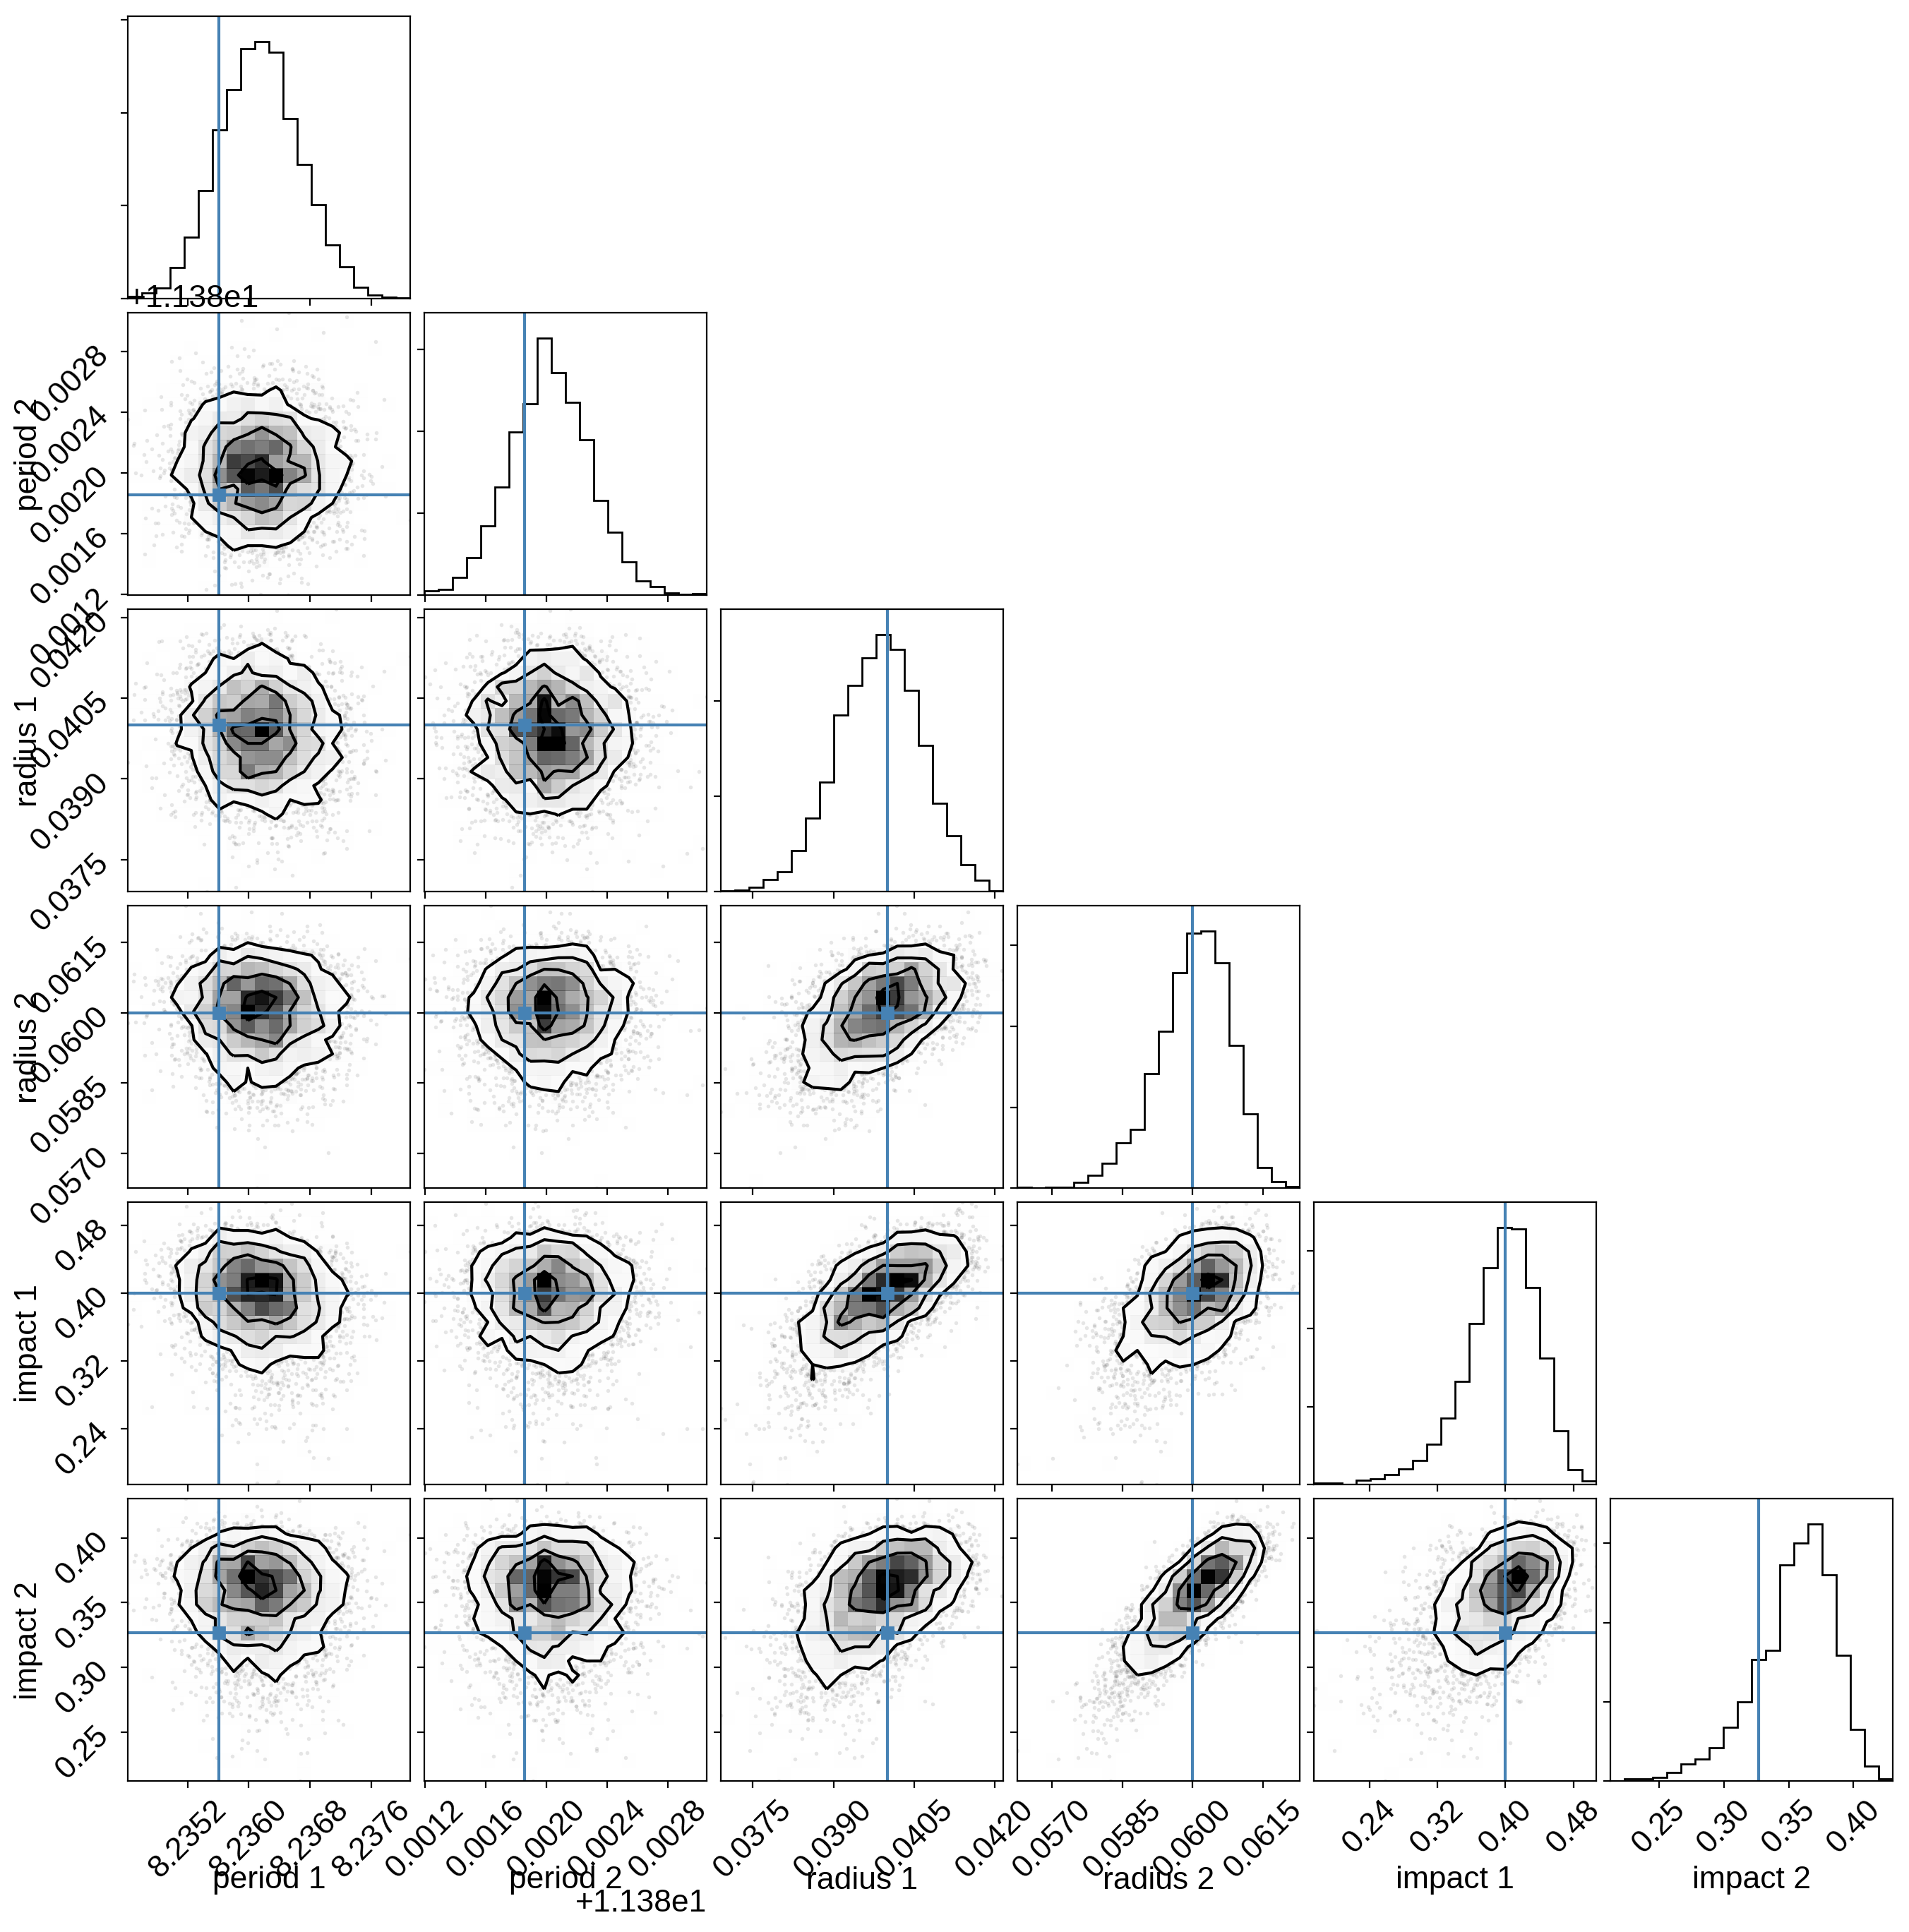

In [10]:
import corner

with model:
    truths = np.concatenate(
        list(map(np.atleast_1d, xo.eval_in_model([orbit.period, r, b])))
    )
samples = pm.trace_to_dataframe(trace, varnames=["period", "r", "b"])
corner.corner(
    samples,
    truths=truths,
    labels=["period 1", "period 2", "radius 1", "radius 2", "impact 1", "impact 2"],
);

We could also plot corner plots of the transit times, but they're not terribly enlightening in this case so let's skip it.

Finally, let's plot the posterior estimates of the the transit times in an O-C diagram:

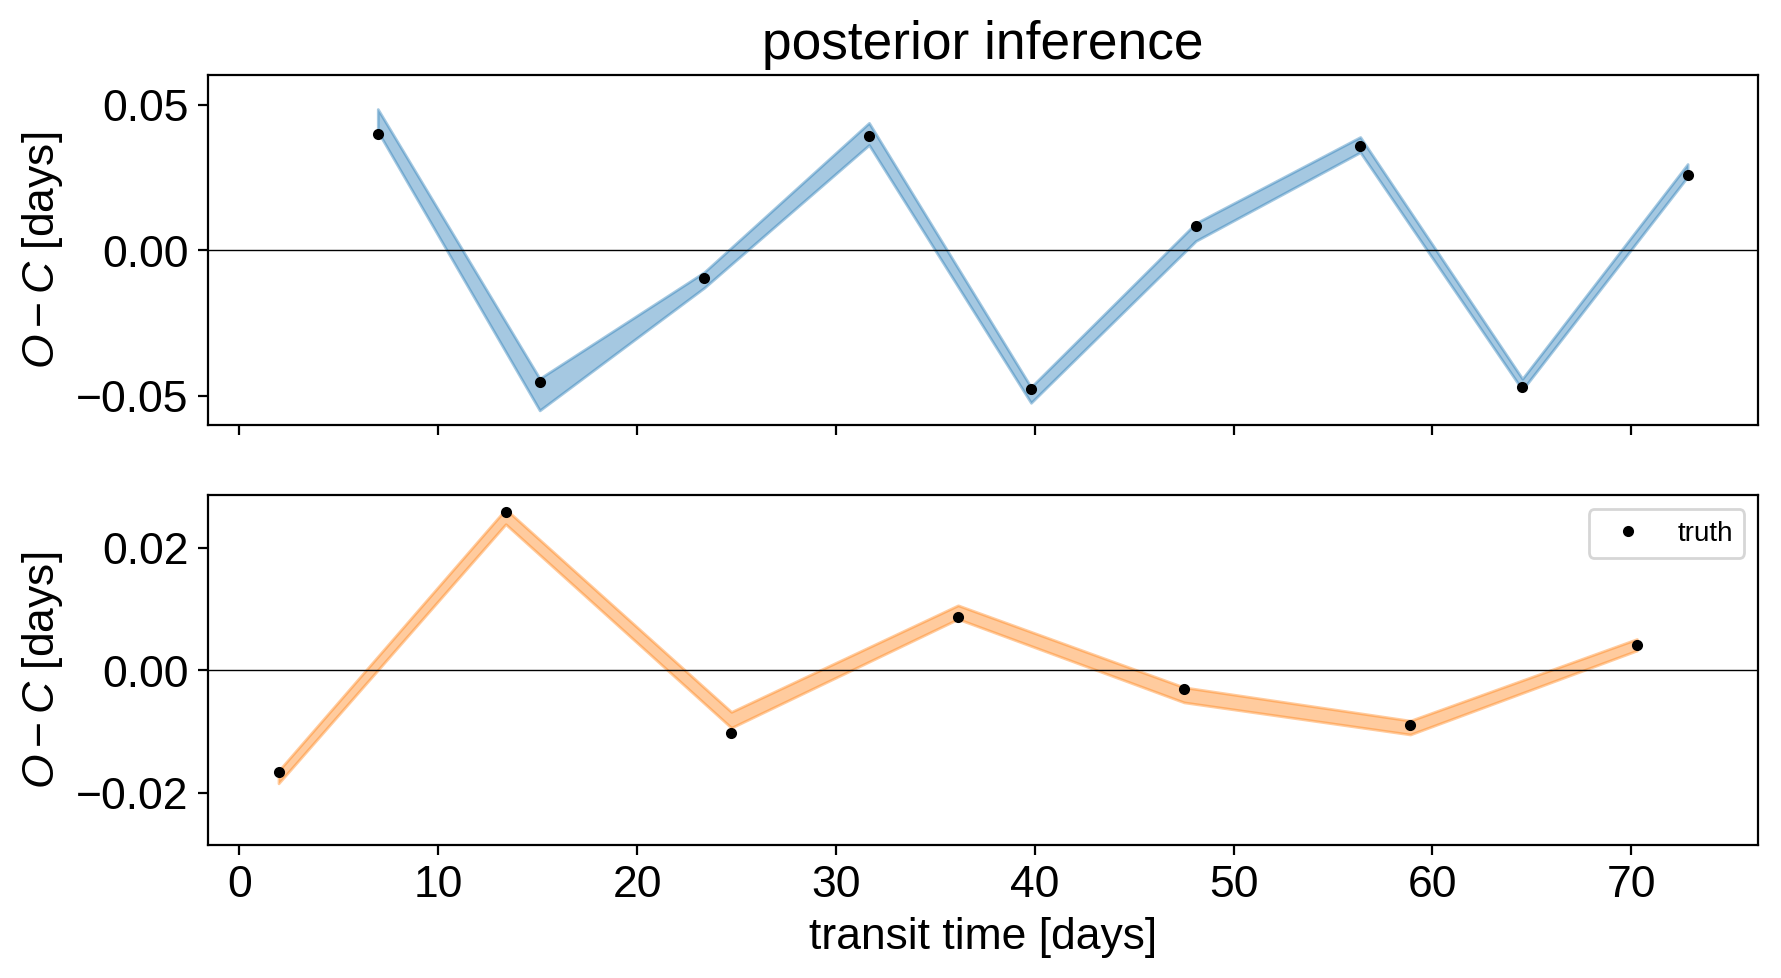

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

q = np.percentile(trace["ttvs_0"], [16, 50, 84], axis=0)
ax1.fill_between(
    np.mean(trace["tts_0"], axis=0), q[0], q[2], color="C0", alpha=0.4, edgecolor="none"
)
ref = np.polyval(
    np.polyfit(true_transit_times[0], true_ttvs[0], 1), true_transit_times[0]
)
ax1.plot(true_transit_times[0], true_ttvs[0] - ref, ".k")
ax1.axhline(0, color="k", lw=0.5)
ax1.set_ylim(np.max(np.abs(ax1.get_ylim())) * np.array([-1, 1]))

ax1.set_ylabel("$O-C$ [days]")

q = np.percentile(trace["ttvs_1"], [16, 50, 84], axis=0)
ax2.fill_between(
    np.mean(trace["tts_1"], axis=0), q[0], q[2], color="C1", alpha=0.4, edgecolor="none"
)
ref = np.polyval(
    np.polyfit(true_transit_times[1], true_ttvs[1], 1), true_transit_times[1]
)
ax2.plot(true_transit_times[1], true_ttvs[1] - ref, ".k", label="truth")
ax2.axhline(0, color="k", lw=0.5)
ax2.set_ylim(np.max(np.abs(ax2.get_ylim())) * np.array([-1, 1]))

ax2.legend(fontsize=10)
ax2.set_ylabel("$O-C$ [days]")
ax2.set_xlabel("transit time [days]")
ax1.set_title("posterior inference");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet v0.2.3},
   month = nov,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
